In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from netCDF4 import Dataset, MFDataset
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta

from scipy import stats
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, skewtest, kurtosis

import sys, warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
def masking_all(x):
    if x.notnull().sum() ==25:
        return x
    else:
        return np.nan

In [4]:
dir = './'
f1 = sorted(glob.glob(dir+'CI_mixing_diag_final_corr/*_CI_prmask_PBLH.csv'))

pairings = ["SWC1_LE","SWC1_H","SWC1_EF","SWC1_NETRAD",         # Land --> Heat flux
            "LE_QA","EF_QA","H_TA",                             # Heat flux --> Near-surface meteorology
            "SWC1_LCL",                                         # Land --> Near-surface meteorology
            "LE_PBLH","H_PBLH","LE_LCL","H_LCL","EF_LCL","NETRAD_LCL", # Heat flux --> PBL characteristics
            "QA_LCL","TA_LCL"]                                         #Near-surface meteorology --> PBL characteristics


month = [x for x in range(1,13)]
season = ["MJJAS"]
season_mon = np.array([[4,5,6,7,8]])

tci    = np.empty([len(pairings),len(f1),len(month),25])
tci_r  = np.empty([len(pairings),len(f1),len(month),25])
tci_p  = np.empty([len(pairings),len(f1),len(month),25])
tci_ssd = np.empty([len(pairings),len(f1),len(month),25])
tci_tsd = np.empty([len(pairings),len(f1),len(month),25])
loco_t = np.empty([len(f1),len(month),25])
loco_q = np.empty([len(f1),len(month),25])
loco_den = np.empty([len(f1),len(month),25])
loco_pbl = np.empty([len(f1),len(month),25])
loco_ef = np.empty([len(f1),len(month),25])
loco_sm = np.empty([len(f1),len(month),25])
loco_ta = np.empty([len(f1),len(month),25])
loco_lh = np.empty([len(f1),len(month),25])
loco_sh = np.empty([len(f1),len(month),25])
sv = np.empty([len(pairings),len(f1),len(month),25])
tv = np.empty([len(pairings),len(f1),len(month),25])
tci[:] = np.nan
tci_r[:] = np.nan
tci_p[:] = np.nan
tci_ssd[:] = np.nan
tci_tsd[:] = np.nan
loco_t[:] = np.nan
loco_q[:] = np.nan
loco_den[:] = np.nan
loco_pbl[:] = np.nan
loco_ef[:] = np.nan
loco_sm[:] = np.nan
loco_ta[:] = np.nan
loco_lh[:] = np.nan
loco_sh[:] = np.nan
sv[:] = np.nan
tv[:] = np.nan

lon = np.empty([len(f1)])
lat = np.empty([len(f1)])
site = [None] * len(f1)
igbp = [None] * len(f1)
lon[:] = np.nan
lat[:] = np.nan

for ff,f in enumerate(f1):
    f_siteid = f.split("/")[2].split("CI")[0]
    f2 = sorted(glob.glob(dir+'FULLSET/'+f_siteid+'site.csv'))
    
    df = pd.read_csv(f,sep=",")
    df1 = pd.read_csv(f2[0],sep=",")
    site[ff] = df1['Site ID'].item()
    lon[ff] = df1['Longitude'].item()
    lat[ff] = df1['Latitude'].item()
    igbp[ff] = df1['IGBP type'].item()
    for pp,p in enumerate(pairings):
        for mm,m in enumerate(month):
            
            if df1['Latitude'].item() < 0:
                m2 = m-6
                if m2 <= 0:
                    m3 = m2+12
                else:
                    m3 = m2
                
                val = df[p][(df['month']==m3)]
                val1 = df[p+"_R"][(df['month']==m3)]
                val2 = df[p+"_SSD"][(df['month']==m3)]
                val3 = df[p+"_TSD"][(df['month']==m3)]
                val4 = df[p+"_SM"][(df['month']==m3)]
                val5 = df[p+"_TM"][(df['month']==m3)]
                pt = df[p+"_pval"][(df['month']==m3)]
                if pp == 0:
                    val6 = df["ME_MEAN"][(df['month']==m3)]
                    val7 = df["TE_MEAN"][(df['month']==m3)]
                    val8 = df["DEN_MEAN"][(df['month']==m3)]
                    val9 = df["PBLH_MEAN"][(df['month']==m3)]
                    val10 = df["SWC1_EF_TM"][(df['month']==m3)]
                    val11 = df["SWC1_EF_SM"][(df['month']==m3)]
                    val12 = df["H_TA_TM"][(df['month']==m3)]
                    val13 = df["SWC1_LE_TM"][(df['month']==m3)]
                    val14 = df["SWC1_H_TM"][(df['month']==m3)]
            else:
                val = df[p][(df['month']==m)]
                val1 = df[p+"_R"][(df['month']==m)]
                val2 = df[p+"_SSD"][(df['month']==m)]
                val3 = df[p+"_TSD"][(df['month']==m)]
                val4 = df[p+"_SM"][(df['month']==m)]
                val5 = df[p+"_TM"][(df['month']==m)]
                pt = df[p+"_pval"][(df['month']==m)]
                if pp == 0:
                    val6 = df["ME_MEAN"][(df['month']==m)]
                    val7 = df["TE_MEAN"][(df['month']==m)]
                    val8 = df["DEN_MEAN"][(df['month']==m)]
                    val9 = df["PBLH_MEAN"][(df['month']==m)]
                    val10 = df["SWC1_EF_TM"][(df['month']==m)]
                    val11 = df["SWC1_EF_SM"][(df['month']==m)]
                    val12 = df["H_TA_TM"][(df['month']==m)]
                    val13 = df["SWC1_LE_TM"][(df['month']==m)]
                    val14 = df["SWC1_H_TM"][(df['month']==m)]

            tci[pp,ff,mm,:] = masking_all(val)
            tci_r[pp,ff,mm,:] = masking_all(val1)
            tci_p[pp,ff,mm,:] = masking_all(pt)
            tci_ssd[pp,ff,mm,:] = masking_all(val2)
            tci_tsd[pp,ff,mm,:] = masking_all(val3)
            sv[pp,ff,mm,:] = masking_all(val4)
            tv[pp,ff,mm,:] = masking_all(val5)
            
            del val
            del val1
            del pt
            del val2
            del val3
            del val4
            del val5
            
            if pp == 0:
                loco_q[ff,mm,:] = masking_all(val6)
                loco_t[ff,mm,:] = masking_all(val7)
                loco_den[ff,mm,:] = masking_all(val8)
                loco_pbl[ff,mm,:] = masking_all(val9)
                loco_ef[ff,mm,:] = masking_all(val10)
                loco_sm[ff,mm,:] = masking_all(val11)
                loco_ta[ff,mm,:] = masking_all(val12)
                loco_lh[ff,mm,:] = masking_all(val13)
                loco_sh[ff,mm,:] = masking_all(val14)
                
                del val6
                del val7
                del val8
                del val9
                del val10
                del val11
                del val12
                del val13
                del val14


In [5]:
mv1 = 0
mv2 = 1
mv3 = 10
mv4 = 11
loco_lcl = np.empty([len(f1),len(month),25])
loco_lcl[:] = np.nan

mask = ( np.isnan(tci[mv1,:,:,:]) | np.isnan(tci[mv2,:,:,:]) | np.isnan(tci[mv3,:,:,:]) | np.isnan(tci[mv4,:,:,:]) |  
        np.isnan(loco_q) | np.isnan(loco_t) |  np.isnan(loco_lh) | np.isnan(loco_sh) | np.isnan(loco_den) | np.isnan(loco_pbl) )
tci[mv1,:,:,:] = np.where( mask, np.nan, tci[mv1,:,:,:])
tci[mv2,:,:,:] = np.where( mask, np.nan, tci[mv2,:,:,:])
tci[mv3,:,:,:] = np.where( mask, np.nan, tci[mv3,:,:,:])
tci[mv4,:,:,:] = np.where( mask, np.nan, tci[mv4,:,:,:])
tci_r[mv1,:,:,:] = np.where( mask, np.nan, tci_r[mv1,:,:,:])
tci_r[mv2,:,:,:] = np.where( mask, np.nan, tci_r[mv2,:,:,:])
tci_r[mv3,:,:,:] = np.where( mask, np.nan, tci_r[mv3,:,:,:])
tci_r[mv4,:,:,:] = np.where( mask, np.nan, tci_r[mv4,:,:,:])
tci_p[mv1,:,:,:] = np.where( mask, np.nan, tci_p[mv1,:,:,:])
tci_p[mv2,:,:,:] = np.where( mask, np.nan, tci_p[mv2,:,:,:])
tci_p[mv3,:,:,:] = np.where( mask, np.nan, tci_p[mv3,:,:,:])
tci_p[mv4,:,:,:] = np.where( mask, np.nan, tci_p[mv4,:,:,:])
tci_p[2,:,:,:] = np.where( mask, np.nan, tci_p[2,:,:,:])
tci_tsd[mv1,:,:,:] = np.where( mask, np.nan, tci_tsd[mv1,:,:,:])
tci_tsd[mv2,:,:,:] = np.where( mask, np.nan, tci_tsd[mv2,:,:,:])
tci_tsd[mv3,:,:,:] = np.where( mask, np.nan, tci_tsd[mv3,:,:,:])
tci_tsd[mv4,:,:,:] = np.where( mask, np.nan, tci_tsd[mv4,:,:,:])
loco_q = np.where( mask, np.nan, loco_q)
loco_t = np.where( mask, np.nan, loco_t)
loco_lh = np.where( mask, np.nan, loco_lh)
loco_sh = np.where( mask, np.nan, loco_sh)
loco_den = np.where( mask, np.nan, loco_den)
loco_pbl = np.where( mask, np.nan, loco_pbl)
loco_lcl = np.where( mask, np.nan, tv[mv4,:,:,:])
loco_sm = np.where( mask, np.nan, loco_sm)
loco_ta = np.where( mask, np.nan, loco_ta)

In [6]:
vidx = [i for i,col in enumerate(igbp) if col in 'SNO'] # mask out where the vegetation type is "SNO"
tci[:,vidx,:,:] = np.nan
tci_r[:,vidx,:,:] = np.nan
tci_p[:,vidx,:,:] = np.nan
tci_tsd[:,vidx,:,:] = np.nan
loco_q[vidx,:,:] = np.nan
loco_t[vidx,:,:] = np.nan
loco_lh[vidx,:,:] = np.nan
loco_sh[vidx,:,:] = np.nan
loco_den[vidx,:,:] = np.nan
loco_pbl[vidx,:,:] = np.nan
loco_lcl[vidx,:,:] = np.nan
loco_sm[vidx,:,:] = np.nan
loco_ta[vidx,:,:] = np.nan

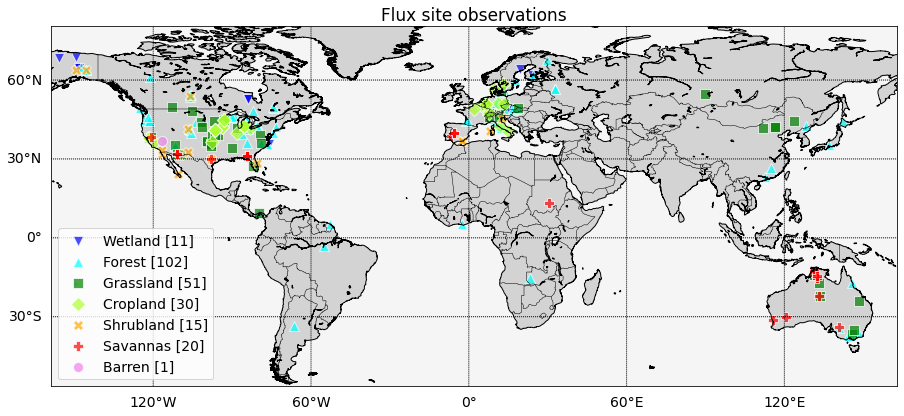

In [7]:
# --- Build Map ---
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
    
region = 'glb'
fname="./fig_final/FluxTowers_veg_"+region+".png"

sea = 0
s = season_mon[sea]
fig = plt.figure(figsize=(13,5))
ax = fig.add_axes([0.,0.,1.0,1.0])

map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
              llcrnrlon=lon.min()-1.5, llcrnrlat=lat.min()-1.5, urcrnrlon=lon.max()+1.5, urcrnrlat=lat.max()+1.5)

map.drawcoastlines()
map.drawcountries()
map.drawlsmask(land_color='lightgrey',ocean_color='whitesmoke',lakes=True)
map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=14) # labels=[left,right,upper,bottom]
map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=14)
    
colors = ["blue","aqua","green","greenyellow","orange","red","violet"]
markers = ["v","^","s","D","X","P","o","h"]
veg = ["Wetland","Forest","Grassland","Cropland","Shrubland","Savannas","Barren"]

for v,veg_type in enumerate(veg):
    
    if veg_type == "Forest":
        veg_igbp = ["ENF","EBF","DNF","DBF","MF"]
    elif veg_type == "Shrubland":
        veg_igbp = ["CSH","OSH"]
    elif veg_type == "Savannas":
        veg_igbp = ["WSA","SAV"]
    elif veg_type == "Grassland":
        veg_igbp = ["GRA"]
    elif veg_type == "Cropland":
        veg_igbp = ["CRO","CVM"]
    elif veg_type == "Wetland":
        veg_igbp = ["WET"]
    elif veg_type == "Barren":
        veg_igbp = ["BSV"]
    vidx = [i for i,col in enumerate(igbp) if col in veg_igbp]
    
    # mm = ( lon[vidx] >= slon ) & ( lon[vidx] <= elon ) & ( lat[vidx] >= slat ) & ( lat[vidx] <= elat ) & ~np.isnan(np.nanmean(tci[0,:,s,0][:,vidx],axis=0)) & ~np.isnan(np.nanmean(tci[1,:,s,0][:,vidx],axis=0)) & ~np.isnan(np.nanmean(tci[10,:,s,0][:,vidx],axis=0)) & ~np.isnan(np.nanmean(tci[11,:,s,0][:,vidx],axis=0))
    mm = ~np.isnan(np.nanmean(tci[0,:,s,0][:,vidx],axis=0)) & ~np.isnan(np.nanmean(tci[1,:,s,0][:,vidx],axis=0)) & ~np.isnan(np.nanmean(tci[10,:,s,0][:,vidx],axis=0)) & ~np.isnan(np.nanmean(tci[11,:,s,0][:,vidx],axis=0))
    map.scatter(lon[vidx][mm], lat[vidx][mm], s=100, label=veg_type+" [{}]".format(mm.sum()), facecolors=colors[v], marker=markers[v], edgecolors='w', alpha=0.7)
      

plt.title("Flux site observations",fontsize=17)
plt.legend(fontsize=14 , labelspacing=0.5, columnspacing=0.5, loc='lower left')
plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [11]:
def scatter_filled_kde(x, y, ax, ax_histx, ax_histy, size, color, mark, alp, xlim, ylim, xyax):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    sc = ax.scatter(x, y, s=size, color=color, alpha=alp)
    # sc = ax.scatter(x, y, s=size, facecolors='none', edgecolors=color, alpha=alp)
    ax.tick_params(labelsize=14)
    ax.set_xlabel(xyax[0],fontsize=15)
    ax.set_ylabel(xyax[1],fontsize=15)
    ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
    ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # m, b = np.polyfit(x, y, 1)
    # ax.plot(x, m*x+b ,linewidth=1.2 , color=color, linestyle='solid',alpha=0.6)
    # ax.plot(np.median(x), np.median(y), color=color, marker=mark, markersize=13,markeredgecolor='black', alpha=0.7)
    ax.plot(np.mean(x), np.mean(y), color=color, marker=mark, markersize=13,markeredgecolor='black', alpha=0.7)

    
    kde = stats.gaussian_kde(x)
    xx = np.linspace(xlim[0], xlim[1], 100)
    ax_histx.plot(xx, kde(xx)/kde(xx).max(),color=color)
    ax_histx.set_ylim(0,1.02)
    
    kde = stats.gaussian_kde(y)
    yy = np.linspace(ylim[0], ylim[1], 100)
    ax_histy.plot(kde(yy)/kde(yy).max(), yy,color=color)
    ax_histy.set_xlim(0,1.02)
    
def scatter_empty_kde(x, y, ax, ax_histx, ax_histy, size, color, mark, alp, xlim, ylim, xyax):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    # sc = ax.scatter(x, y, s=size, color=color, alpha=alp)
    sc = ax.scatter(x, y, s=size, facecolors='none', edgecolors=color, alpha=alp)
    ax.tick_params(labelsize=14)
    ax.set_xlabel(xyax[0],fontsize=15)
    ax.set_ylabel(xyax[1],fontsize=15)
    ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
    ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # m, b = np.polyfit(x, y, 1)
    # ax.plot(x, m*x+b ,linewidth=1.2 , color=color, linestyle='solid',alpha=0.6)
    # ax.plot(np.median(x), np.median(y), color=color, marker=mark, markersize=13,markeredgecolor='black', alpha=0.7)
    ax.plot(np.mean(x), np.mean(y), color=color, marker=mark, markersize=13,markeredgecolor='black', alpha=0.9)

    
    kde = stats.gaussian_kde(x)
    xx = np.linspace(xlim[0], xlim[1], 100)
    ax_histx.plot(xx, kde(xx)/kde(xx).max(),color=color)
    ax_histx.set_ylim(0,1.02)
    
    kde = stats.gaussian_kde(y)
    yy = np.linspace(ylim[0], ylim[1], 100)
    ax_histy.plot(kde(yy)/kde(yy).max(), yy,color=color)
    ax_histy.set_xlim(0,1.02)
  
    
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

def add_identity_r(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low*100, high*100], [-low*100, -high*100])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

x axis =0, y axis =1


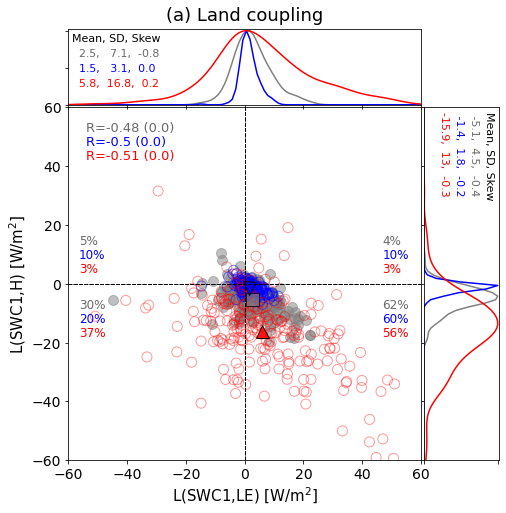

In [12]:
fig = plt.figure(figsize=(7,7))

n = np.array([[23,0,1]]).T
d = np.array([[11,12,13]]).T

m1 = 0
m2 = 1
if m1 ==0 and m2==1:
    xylab = ["L(SWC1,LE) [W/m$^2$]", "L(SWC1,H) [W/m$^2$]"]
elif m1 ==10 and m2==11:
    xylab = ["A(LE,LCL) [m]", "A(H,LCL) [m]"]
    
sea = 0
s = season_mon[sea]
fname="./fig_final/FluxTowers_TCI_"+pairings[m1]+"-"+pairings[m2]+"_"+season[sea]+"_kde_prmask.png"

print("x axis ={}, y axis ={}".format(m1,m2))


if m1==0 or m1==1:
    xlim = [-60, 60]
elif m1==2:
    xlim = [-0.26, 0.26]
elif m1==3:
    xlim = [-140, 140]
elif m1==4 or m1==5:
    xlim = [-0.003, 0.003]
elif m1==6:
    xlim = [-7, 7]
elif m1>=8 and m1<=9:
    xlim = [-500, 500]
elif m1>=10 and m1<=14:
    xlim = [-700, 700]

if m2==0 or m2==1:
    ylim = [-60, 60]
elif m2==2:
    ylim = [-0.26, 0.26]
elif m2==3:
    ylim = [-140, 140]
elif m2==4 or m2==5:
    ylim = [-0.003, 0.003]
elif m2==6:
    ylim = [-7, 7]
elif m2>=8 and m2<=9:
    ylim = [-500, 500]
elif m2>=10 and m2<=14:
    ylim = [-700, 700]


mv1 = 0
mv2 = 1
mv3 = 10
mv4 = 11
vidx = [i for i in range(len(lon))]


# definitions for the axes
left, width = 0.1, 0.7
bottom, height = 0.1, 0.7
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.15]
rect_histy = [left + width + spacing, bottom, 0.15, height]

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

x1, y1 = np.nanmean(tci[m1,:,s,0],axis=0), np.nanmean(tci[m2,:,s,0],axis=0)
mm = ~np.isnan(np.nanmean(tci[mv1,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv2,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv3,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv4,:,s,0],axis=0))
xx1, yy1 = x1[mm], y1[mm]
cr1 = stats.pearsonr(x1[mm], y1[mm])
a1, b1 = np.polyfit(x1[mm], y1[mm], 1)
scatter_filled_kde(x1[mm], y1[mm], ax, ax_histx, ax_histy, 100, 'gray', 's', 0.5, xlim, ylim, xylab)

x1, y1 = np.nanmean(np.nanmean(tci[m1,:,s,n],axis=0),axis=0), np.nanmean(np.nanmean(tci[m2,:,s,n],axis=0),axis=0)
mm = ~np.isnan(np.nanmean(np.nanmean(tci[mv1,:,s,n],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv2,:,s,n],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv3,:,s,n],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv4,:,s,n],axis=0),axis=0))
xx2, yy2 = x1[mm], y1[mm]
cr2 = stats.pearsonr(x1[mm], y1[mm])
a2, b2 = np.polyfit(x1[mm], y1[mm], 1)
scatter_empty_kde(x1[mm], y1[mm], ax, ax_histx, ax_histy, 100, 'blue', 'v', 0.5, xlim, ylim, xylab)

x1, y1 = np.nanmean(np.nanmean(tci[m1,:,s,d],axis=0),axis=0), np.nanmean(np.nanmean(tci[m2,:,s,d],axis=0),axis=0)
mm = ~np.isnan(np.nanmean(np.nanmean(tci[mv1,:,s,d],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv2,:,s,d],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv3,:,s,d],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv4,:,s,d],axis=0),axis=0))
xx3, yy3 = x1[mm], y1[mm]
a3, b3 = np.polyfit(x1[mm], y1[mm], 1)
cr3 = stats.pearsonr(x1[mm], y1[mm])
scatter_empty_kde(x1[mm], y1[mm], ax, ax_histx, ax_histy, 100, 'red', '^', 0.4, xlim, ylim, xylab)


if m1 ==10 and m2==11:
    add_identity(ax, color='black', linestyle='--',linewidth=1.0)
    # rat1 = (xx1>yy1).sum() / int(len(xx1)) * 100.
    # rat2 = (xx2>yy2).sum() / int(len(xx1)) * 100.
    # rat3 = (xx3>yy3).sum() / int(len(xx1)) * 100.
    # ax.annotate('D:{}%\nA:{}%\nP:{}%\n'
    #             .format(int(round(rat1,0)),int(round(rat2,0)),int(round(rat3,0))),
    #             xy=(0.87, 0.91), xycoords='axes fraction',
    #             horizontalalignment='left', verticalalignment='top', rotation=45,
    #             fontsize=10)
    # rat1 = 100-rat1 
    # rat2 = 100-rat2
    # rat3 = 100-rat3 
    # ax.annotate('D:{}%\nA:{}%\nP:{}%\n'
    #             .format(int(round(rat1,0)),int(round(rat2,0)),int(round(rat3,0))),
    #             xy=(0.78, 1.0), xycoords='axes fraction',
    #             horizontalalignment='left', verticalalignment='top', rotation=45,
    #             fontsize=10)


ax.annotate('R={} ({})'.format(round(cr1[0],2),round(cr1[1],3)),color='dimgrey',
            xy=(0.05, 0.96), xycoords='axes fraction', 
            horizontalalignment='left', verticalalignment='top',
            fontsize=13)
ax.annotate('R={} ({})'.format(round(cr2[0],2),round(cr2[1],3)),color='blue',
            xy=(0.05, 0.92), xycoords='axes fraction', 
            horizontalalignment='left', verticalalignment='top',
            fontsize=13)
ax.annotate('R={} ({})'.format(round(cr3[0],2),round(cr3[1],3)),color='red',
            xy=(0.05, 0.88), xycoords='axes fraction', 
            horizontalalignment='left', verticalalignment='top',
            fontsize=13)


# ax.annotate('y={}x{:+.2f}'.format(round(a1,2),round(b1,2)),
#             xy=(0.05, 0.20), xycoords='axes fraction', color='dimgrey',
#             horizontalalignment='left', verticalalignment='top',
#             fontsize=13)
# ax.annotate('y={}x{:+.2f}'.format(round(a2,2),round(b2,2)),
#             xy=(0.05, 0.15), xycoords='axes fraction', color='blue',
#             horizontalalignment='left', verticalalignment='top',
#             fontsize=13)
# ax.annotate('y={}x{:+.2f}'.format(round(a3,2),round(b3,2)),
#             xy=(0.05, 0.10), xycoords='axes fraction', color='red',
#             horizontalalignment='left', verticalalignment='top',
#             fontsize=13)

ax_histx.annotate('Mean, SD, Skew',color='black',xy=(0.01, 0.95), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',fontsize=11)

ax_histx.annotate('  {},   {},  {}'.format(round(np.mean(xx1),1),round(np.std(xx1),1),round(skew(xx1),1)),color='dimgrey',
                  xy=(0.01, 0.75), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11)
ax_histx.annotate('  {},   {},  {}'.format(round(np.mean(xx2),1),round(np.std(xx2),1),round(skew(xx2),1)),color='blue',
                  xy=(0.01, 0.55), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11)
ax_histx.annotate('  {},  {},  {}'.format(round(np.mean(xx3),1),round(np.std(xx3),1),round(skew(xx3),1)),color='red',
                  xy=(0.01, 0.35), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11)


ax_histy.annotate('Mean, SD, Skew',color='black',xy=(0.80, 0.99), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',fontsize=11, rotation=-90)
ax_histy.annotate(' {},  {},  {}'.format(round(np.mean(yy1),1),round(np.std(yy1),1),round(skew(yy1),1)),color='dimgrey',
                  xy=(0.60, 0.99), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11, rotation=-90)
ax_histy.annotate(' {},  {},  {}'.format(round(np.mean(yy2),1),round(np.std(yy2),1),round(skew(yy2),1)),color='blue',
                  xy=(0.40, 0.99), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11, rotation=-90)
ax_histy.annotate('{},  {},  {}'.format(round(np.mean(yy3),1),int(round(np.std(yy3),0)),round(skew(yy3),1)),color='red',
                  xy=(0.20, 0.99), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11, rotation=-90)

rm1 = (xx1>0) & (yy1>0)
rm2 = (xx2>0) & (yy2>0)
rm3 = (xx3>0) & (yy3>0)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.89, 0.64), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.89, 0.60), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.89, 0.56), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)

rm1 = (xx1<0) & (yy1>0)
rm2 = (xx2<0) & (yy2>0)
rm3 = (xx3<0) & (yy3>0)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.03, 0.64), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.03, 0.60), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.03, 0.56), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)


rm1 = (xx1<0) & (yy1<0)
rm2 = (xx2<0) & (yy2<0)
rm3 = (xx3<0) & (yy3<0)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.03, 0.46), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.03, 0.42), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.03, 0.38), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)


rm1 = (xx1>0) & (yy1<0)
rm2 = (xx2>0) & (yy2<0)
rm3 = (xx3>0) & (yy3<0)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.89, 0.46), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.89, 0.42), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.89, 0.38), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)


if m1 ==0 and m2==1:
    # plt.suptitle('Land coupling ({})'.format(season[sea]),x=0.45,y=1.0,fontsize=18)
    plt.suptitle('(a) Land coupling',x=0.45,y=1.0,fontsize=18)
elif m1 ==10 and m2==11:
    # plt.suptitle('Atmospheric coupling ({})'.format(season[sea]),x=0.45,y=1.0,fontsize=18)
    plt.suptitle('(b) Atmospheric coupling',x=0.45,y=1.0,fontsize=18)
plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)

plt.show()

x axis =10, y axis =11


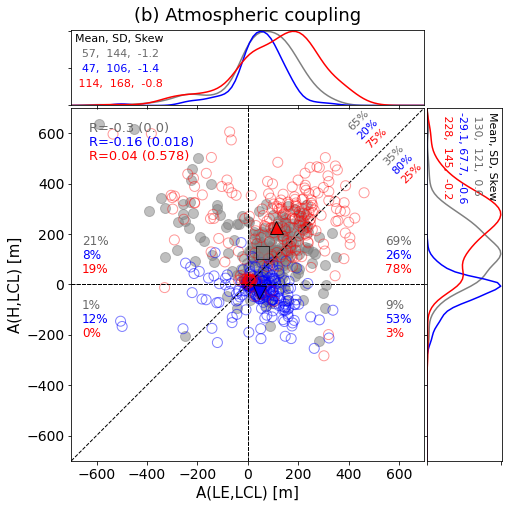

In [13]:
fig = plt.figure(figsize=(7,7))

n = np.array([[23,0,1]]).T
d = np.array([[11,12,13]]).T

m1 = 10
m2 = 11
if m1 ==0 and m2==1:
    xylab = ["L(SWC1,LE) [W/m$^2$]", "L(SWC1,H) [W/m$^2$]"]
elif m1 ==10 and m2==11:
    xylab = ["A(LE,LCL) [m]", "A(H,LCL) [m]"]
    

sea = 0
s = season_mon[sea]
fname="./fig_final/FluxTowers_TCI_"+pairings[m1]+"-"+pairings[m2]+"_"+season[sea]+"_kde_prmask.png"

print("x axis ={}, y axis ={}".format(m1,m2))


if m1==0 or m1==1:
    xlim = [-70, 70]
elif m1==2:
    xlim = [-0.26, 0.26]
elif m1==3:
    xlim = [-140, 140]
elif m1==4 or m1==5:
    xlim = [-0.003, 0.003]
elif m1==6:
    xlim = [-7, 7]
elif m1>=8 and m1<=9:
    xlim = [-500, 500]
elif m1>=10 and m1<=14:
    xlim = [-700, 700]

if m2==0 or m2==1:
    ylim = [-70, 70]
elif m2==2:
    ylim = [-0.26, 0.26]
elif m2==3:
    ylim = [-140, 140]
elif m2==4 or m2==5:
    ylim = [-0.003, 0.003]
elif m2==6:
    ylim = [-7, 7]
elif m2>=8 and m2<=9:
    ylim = [-500, 500]
elif m2>=10 and m2<=14:
    ylim = [-700, 700]


mv1 = 0
mv2 = 1
mv3 = 10
mv4 = 11
vidx = [i for i in range(len(lon))]


# definitions for the axes
left, width = 0.1, 0.7
bottom, height = 0.1, 0.7
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.15]
rect_histy = [left + width + spacing, bottom, 0.15, height]

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

x1, y1 = np.nanmean(tci[m1,:,s,0],axis=0), np.nanmean(tci[m2,:,s,0],axis=0)
mm = ~np.isnan(np.nanmean(tci[mv1,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv2,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv3,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv4,:,s,0],axis=0))
xx1, yy1 = x1[mm], y1[mm]
cr1 = stats.pearsonr(x1[mm], y1[mm])
a1, b1 = np.polyfit(x1[mm], y1[mm], 1)
scatter_filled_kde(x1[mm], y1[mm], ax, ax_histx, ax_histy, 100, 'gray', 's', 0.5, xlim, ylim, xylab)

x1, y1 = np.nanmean(np.nanmean(tci[m1,:,s,n],axis=0),axis=0), np.nanmean(np.nanmean(tci[m2,:,s,n],axis=0),axis=0)
mm = ~np.isnan(np.nanmean(np.nanmean(tci[mv1,:,s,n],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv2,:,s,n],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv3,:,s,n],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv4,:,s,n],axis=0),axis=0))
xx2, yy2 = x1[mm], y1[mm]
cr2 = stats.pearsonr(x1[mm], y1[mm])
a2, b2 = np.polyfit(x1[mm], y1[mm], 1)
scatter_empty_kde(x1[mm], y1[mm], ax, ax_histx, ax_histy, 100, 'blue', 'v', 0.5, xlim, ylim, xylab)

x1, y1 = np.nanmean(np.nanmean(tci[m1,:,s,d],axis=0),axis=0), np.nanmean(np.nanmean(tci[m2,:,s,d],axis=0),axis=0)
mm = ~np.isnan(np.nanmean(np.nanmean(tci[mv1,:,s,d],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv2,:,s,d],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv3,:,s,d],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv4,:,s,d],axis=0),axis=0))
xx3, yy3 = x1[mm], y1[mm]
a3, b3 = np.polyfit(x1[mm], y1[mm], 1)
cr3 = stats.pearsonr(x1[mm], y1[mm])
scatter_empty_kde(x1[mm], y1[mm], ax, ax_histx, ax_histy, 100, 'red', '^', 0.4, xlim, ylim, xylab)


if m1 ==10 and m2==11:
    add_identity(ax, color='black', linestyle='--',linewidth=1.0)
    rat1 = (xx1>yy1).sum() / int(len(xx1)) * 100.
    rat2 = (xx2>yy2).sum() / int(len(xx1)) * 100.
    rat3 = (xx3>yy3).sum() / int(len(xx1)) * 100.

    ax.annotate('{}%'.format(int(round(rat1,0))),xy=(0.88, 0.90), xycoords='axes fraction',color='dimgrey',
                horizontalalignment='left', verticalalignment='top', rotation=45, fontsize=11)
    ax.annotate('{}%'.format(int(round(rat2,0))),xy=(0.88+0.025, 0.90-0.025), xycoords='axes fraction',color='blue',
                horizontalalignment='left', verticalalignment='top', rotation=45, fontsize=11)
    ax.annotate('{}%'.format(int(round(rat3,0))),xy=(0.88+0.05, 0.90-0.05), xycoords='axes fraction',color='red',
                horizontalalignment='left', verticalalignment='top', rotation=45, fontsize=11)
    rat1 = 100-rat1 
    rat2 = 100-rat2
    rat3 = 100-rat3 

    ax.annotate('{}%'.format(int(round(rat1,0))),xy=(0.78, 1), xycoords='axes fraction',color='dimgrey',
                horizontalalignment='left', verticalalignment='top', rotation=45, fontsize=11)
    ax.annotate('{}%'.format(int(round(rat2,0))),xy=(0.78+0.025, 1-0.025), xycoords='axes fraction',color='blue',
                horizontalalignment='left', verticalalignment='top', rotation=45, fontsize=11)
    ax.annotate('{}%'.format(int(round(rat3,0))),xy=(0.78+0.05, 1-0.05), xycoords='axes fraction',color='red',
                horizontalalignment='left', verticalalignment='top', rotation=45, fontsize=11)



ax.annotate('R={} ({})'.format(round(cr1[0],2),round(cr1[1],3)),color='dimgrey',
            xy=(0.05, 0.96), xycoords='axes fraction', 
            horizontalalignment='left', verticalalignment='top',
            fontsize=13)
ax.annotate('R={} ({})'.format(round(cr2[0],2),round(cr2[1],3)),color='blue',
            xy=(0.05, 0.92), xycoords='axes fraction', 
            horizontalalignment='left', verticalalignment='top',
            fontsize=13)
ax.annotate('R={} ({})'.format(round(cr3[0],2),round(cr3[1],3)),color='red',
            xy=(0.05, 0.88), xycoords='axes fraction', 
            horizontalalignment='left', verticalalignment='top',
            fontsize=13)


# ax.annotate('y={}x{:+.1f}'.format(round(a1,2),round(b1,1)),
#             xy=(0.69, 0.20), xycoords='axes fraction', color='dimgrey',
#             horizontalalignment='left', verticalalignment='top',
#             fontsize=13)
# ax.annotate('y={}x{:+.1f}'.format(round(a2,2),round(b2,1)),
#             xy=(0.69, 0.15), xycoords='axes fraction', color='blue',
#             horizontalalignment='left', verticalalignment='top',
#             fontsize=13)
# ax.annotate('y={}x{:+.1f}'.format(round(a3,2),round(b3,1)),
#             xy=(0.69, 0.10), xycoords='axes fraction', color='red',
#             horizontalalignment='left', verticalalignment='top',
#             fontsize=13)


ax_histx.annotate('Mean, SD, Skew',color='black',xy=(0.01, 0.95), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',fontsize=11)

ax_histx.annotate('  {},  {},  {}'.format(int(round(np.mean(xx1),0)),int(round(np.std(xx1),0)),round(skew(xx1),1)),color='dimgrey',
                  xy=(0.01, 0.75), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11)
ax_histx.annotate('  {},  {},  {}'.format(int(round(np.mean(xx2),0)),int(round(np.std(xx2),0)),round(skew(xx2),1)),color='blue',
                  xy=(0.01, 0.55), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11)
ax_histx.annotate(' {},  {},  {}'.format(int(round(np.mean(xx3),0)),int(round(np.std(xx3),0)),round(skew(xx3),1)),color='red',
                  xy=(0.01, 0.35), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11)


ax_histy.annotate('Mean, SD, Skew',color='black',xy=(0.80, 0.99), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',fontsize=11, rotation=-90)
ax_histy.annotate(' {},  {},  {}'.format(int(round(np.mean(yy1),0)),int(round(np.std(yy1),0)),round(skew(yy1),1)),color='dimgrey',
                  xy=(0.60, 0.99), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11, rotation=-90)
ax_histy.annotate('{}, {},  {}'.format(round(np.mean(yy2),1),round(np.std(yy2),1),round(skew(yy2),1)),color='blue',
                  xy=(0.40, 0.99), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11, rotation=-90)
ax_histy.annotate(' {},  {},  {}'.format(int(round(np.mean(yy3),0)),int(round(np.std(yy3),0)),round(skew(yy3),1)),color='red',
                  xy=(0.20, 0.99), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11, rotation=-90)

rm1 = (xx1>0) & (yy1>0)
rm2 = (xx2>0) & (yy2>0)
rm3 = (xx3>0) & (yy3>0)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.89, 0.64), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.89, 0.60), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.89, 0.56), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)

rm1 = (xx1<0) & (yy1>0)
rm2 = (xx2<0) & (yy2>0)
rm3 = (xx3<0) & (yy3>0)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.03, 0.64), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.03, 0.60), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.03, 0.56), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)


rm1 = (xx1<0) & (yy1<0)
rm2 = (xx2<0) & (yy2<0)
rm3 = (xx3<0) & (yy3<0)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.03, 0.46), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.03, 0.42), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.03, 0.38), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)


rm1 = (xx1>0) & (yy1<0)
rm2 = (xx2>0) & (yy2<0)
rm3 = (xx3>0) & (yy3<0)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.89, 0.46), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.89, 0.42), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.89, 0.38), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)

if m1 ==0 and m2==1:
    # plt.suptitle('Land coupling ({})'.format(season[sea]),x=0.45,y=1.0,fontsize=18)
    plt.suptitle('(a) Land coupling',x=0.45,y=1.0,fontsize=18)
elif m1 ==10 and m2==11:
    # plt.suptitle('Atmospheric coupling ({})'.format(season[sea]),x=0.45,y=1.0,fontsize=18)
    plt.suptitle('(b) Atmospheric coupling',x=0.45,y=1.0,fontsize=18)
plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)

plt.show()

x axis =10, y axis =11


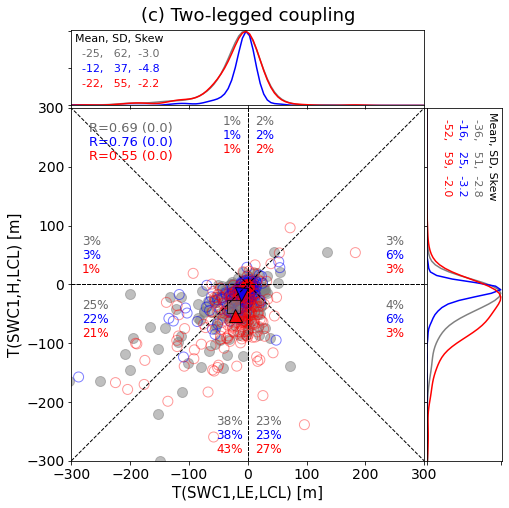

In [14]:
fig = plt.figure(figsize=(7,7))

n = np.array([[23,0,1]]).T
d = np.array([[11,12,13]]).T

m1 = 10
m2 = 11
sea = 0
xylab = ['T(SWC1,LE,LCL) [m]', 'T(SWC1,H,LCL) [m]']
fname="./fig_final/FluxTowers_TCI_SWC1_LE_LCL-SWC1_H_LCL_"+season[sea]+"_kde_prmask.png"

print("x axis ={}, y axis ={}".format(m1,m2))


if m1==0 or m1==1:
    xlim = [-100, 100]
elif m1==2:
    xlim = [-0.26, 0.26]
elif m1==3:
    xlim = [-140, 140]
elif m1==4 or m1==5:
    xlim = [-0.003, 0.003]
elif m1==6:
    xlim = [-7, 7]
elif m1>=7 and m1<=14:
    xlim = [-300, 300]

if m2==0 or m2==1:
    ylim = [-100, 100]
elif m2==2:
    ylim = [-0.26, 0.26]
elif m2==3:
    ylim = [-140, 140]
elif m2==4 or m2==5:
    ylim = [-0.003, 0.003]
elif m2==6:
    ylim = [-7, 7]
elif m2>=7 and m2<=14:
    ylim = [-300, 300]

s = season_mon[sea]

mv1 = 0
mv2 = 1
mv3 = 10
mv4 = 11
vidx = [i for i in range(len(lon))]


# definitions for the axes
left, width = 0.1, 0.7
bottom, height = 0.1, 0.7
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.15]
rect_histy = [left + width + spacing, bottom, 0.15, height]

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

x1, y1 = np.nanmean(tci[m1,:,s,0]*tci_r[0,:,s,0],axis=0), np.nanmean(tci[m2,:,s,0]*tci_r[1,:,s,0],axis=0)
mm = ~np.isnan(np.nanmean(tci[mv1,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv2,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv3,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv4,:,s,0],axis=0))
xx1, yy1 = x1[mm], y1[mm]
cr1 = stats.pearsonr(x1[mm], y1[mm])
a1, b1 = np.polyfit(x1[mm], y1[mm], 1)
scatter_filled_kde(x1[mm], y1[mm], ax, ax_histx, ax_histy, 100, 'gray', 's', 0.5, xlim, ylim, xylab)

x1, y1 = np.nanmean(np.nanmean(tci[m1,:,s,n]*tci_r[0,:,s,n],axis=0),axis=0), np.nanmean(np.nanmean(tci[m2,:,s,n]*tci_r[1,:,s,n],axis=0),axis=0)
mm = ~np.isnan(np.nanmean(np.nanmean(tci[mv1,:,s,n],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv2,:,s,n],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv3,:,s,n],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv4,:,s,n],axis=0),axis=0))
xx2, yy2 = x1[mm], y1[mm]
cr2 = stats.pearsonr(x1[mm], y1[mm])
a2, b2 = np.polyfit(x1[mm], y1[mm], 1)
scatter_empty_kde(x1[mm], y1[mm], ax, ax_histx, ax_histy, 100, 'blue', 'v', 0.5, xlim, ylim, xylab)

x1, y1 = np.nanmean(np.nanmean(tci[m1,:,s,d]*tci_r[0,:,s,d],axis=0),axis=0), np.nanmean(np.nanmean(tci[m2,:,s,d]*tci_r[1,:,s,d],axis=0),axis=0)
mm = ~np.isnan(np.nanmean(np.nanmean(tci[mv1,:,s,d],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv2,:,s,d],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv3,:,s,d],axis=0),axis=0)) & ~np.isnan(np.nanmean(np.nanmean(tci[mv4,:,s,d],axis=0),axis=0))
xx3, yy3 = x1[mm], y1[mm]
a3, b3 = np.polyfit(x1[mm], y1[mm], 1)
cr3 = stats.pearsonr(x1[mm], y1[mm])
scatter_empty_kde(x1[mm], y1[mm], ax, ax_histx, ax_histy, 100, 'red', '^', 0.4, xlim, ylim, xylab)


if m1 ==10 and m2==11:
    add_identity(ax, color='black', linestyle='--',linewidth=1.0)
    add_identity_r(ax, color='black', linestyle='--',linewidth=1.0)
#     rat1 = (xx1>yy1).sum() / int(len(xx1)) * 100.
#     rat2 = (xx2>yy2).sum() / int(len(xx1)) * 100.
#     rat3 = (xx3>yy3).sum() / int(len(xx1)) * 100.

#     ax.annotate('{}%'.format(int(round(rat1,0))),xy=(0.88, 0.90), xycoords='axes fraction',color='dimgrey',
#                 horizontalalignment='left', verticalalignment='top', rotation=45, fontsize=11)
#     ax.annotate('{}%'.format(int(round(rat2,0))),xy=(0.88+0.025, 0.90-0.025), xycoords='axes fraction',color='blue',
#                 horizontalalignment='left', verticalalignment='top', rotation=45, fontsize=11)
#     ax.annotate('{}%'.format(int(round(rat3,0))),xy=(0.88+0.05, 0.90-0.05), xycoords='axes fraction',color='red',
#                 horizontalalignment='left', verticalalignment='top', rotation=45, fontsize=11)
#     rat1 = 100-rat1 
#     rat2 = 100-rat2
#     rat3 = 100-rat3 

#     ax.annotate('{}%'.format(int(round(rat1,0))),xy=(0.78, 1), xycoords='axes fraction',color='dimgrey',
#                 horizontalalignment='left', verticalalignment='top', rotation=45, fontsize=11)
#     ax.annotate('{}%'.format(int(round(rat2,0))),xy=(0.78+0.025, 1-0.025), xycoords='axes fraction',color='blue',
#                 horizontalalignment='left', verticalalignment='top', rotation=45, fontsize=11)
#     ax.annotate('{}%'.format(int(round(rat3,0))),xy=(0.78+0.05, 1-0.05), xycoords='axes fraction',color='red',
#                 horizontalalignment='left', verticalalignment='top', rotation=45, fontsize=11)



ax.annotate('R={} ({})'.format(round(cr1[0],2),round(cr1[1],3)),color='dimgrey',
            xy=(0.05, 0.96), xycoords='axes fraction', 
            horizontalalignment='left', verticalalignment='top',
            fontsize=13)
ax.annotate('R={} ({})'.format(round(cr2[0],2),round(cr2[1],3)),color='blue',
            xy=(0.05, 0.92), xycoords='axes fraction', 
            horizontalalignment='left', verticalalignment='top',
            fontsize=13)
ax.annotate('R={} ({})'.format(round(cr3[0],2),round(cr3[1],3)),color='red',
            xy=(0.05, 0.88), xycoords='axes fraction', 
            horizontalalignment='left', verticalalignment='top',
            fontsize=13)


# ax.annotate('y={}x{:+.2f}'.format(round(a1,2),round(b1,2)),
#             xy=(0.70, 0.20), xycoords='axes fraction', color='dimgrey',
#             horizontalalignment='left', verticalalignment='top',
#             fontsize=13)
# ax.annotate('y={}x{:+.2f}'.format(round(a2,2),round(b2,2)),
#             xy=(0.70, 0.15), xycoords='axes fraction', color='blue',
#             horizontalalignment='left', verticalalignment='top',
#             fontsize=13)
# ax.annotate('y={}x{:+.2f}'.format(round(a3,2),round(b3,2)),
#             xy=(0.70, 0.10), xycoords='axes fraction', color='red',
#             horizontalalignment='left', verticalalignment='top',
#             fontsize=13)


ax_histx.annotate('Mean, SD, Skew',color='black',xy=(0.01, 0.95), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',fontsize=11)

ax_histx.annotate('  {},   {},  {}'.format(int(round(np.mean(xx1),0)),int(round(np.std(xx1),0)),round(skew(xx1),1)),color='dimgrey',
                  xy=(0.01, 0.75), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11)
ax_histx.annotate('  {},   {},  {}'.format(int(round(np.mean(xx2),0)),int(round(np.std(xx2),0)),round(skew(xx2),1)),color='blue',
                  xy=(0.01, 0.55), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11)
ax_histx.annotate('  {},   {},  {}'.format(int(round(np.mean(xx3),0)),int(round(np.std(xx3),0)),round(skew(xx3),1)),color='red',
                  xy=(0.01, 0.35), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11)


ax_histy.annotate('Mean, SD, Skew',color='black',xy=(0.80, 0.99), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',fontsize=11, rotation=-90)
ax_histy.annotate('  {},   {},  {}'.format(int(round(np.mean(yy1),0)),int(round(np.std(yy1),0)),round(skew(yy1),1)),color='dimgrey',
                  xy=(0.60, 0.99), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11, rotation=-90)
ax_histy.annotate('  {},   {},  {}'.format(int(round(np.mean(yy2),0)),int(round(np.std(yy2),0)),round(skew(yy2),1)),color='blue',
                  xy=(0.40, 0.99), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11, rotation=-90)
ax_histy.annotate('  {},   {},  {}'.format(int(round(np.mean(yy3),0)),int(round(np.std(yy3),0)),round(skew(yy3),1)),color='red',
                  xy=(0.20, 0.99), xycoords='axes fraction', 
                  horizontalalignment='left', verticalalignment='top',
                  fontsize=11, rotation=-90)

rm1 = (xx1>0) & (yy1>0) & (xx1>yy1)
rm2 = (xx2>0) & (yy2>0) & (xx2>yy2)
rm3 = (xx3>0) & (yy3>0) & (xx3>yy3)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.89, 0.64), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.89, 0.60), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.89, 0.56), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)

rm1 = (xx1<0) & (yy1>0) & (-xx1>yy1)
rm2 = (xx2<0) & (yy2>0) & (-xx2>yy2)
rm3 = (xx3<0) & (yy3>0) & (-xx3>yy3)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.03, 0.64), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.03, 0.60), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.03, 0.56), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)


rm1 = (xx1<0) & (yy1<0) & (xx1<yy1)
rm2 = (xx2<0) & (yy2<0) & (xx2<yy2)
rm3 = (xx3<0) & (yy3<0) & (xx3<yy3)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.03, 0.46), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.03, 0.42), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.03, 0.38), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)


rm1 = (xx1>0) & (yy1<0) & (-xx1<yy1)
rm2 = (xx2>0) & (yy2<0) & (-xx2<yy2)
rm3 = (xx3>0) & (yy3<0) & (-xx3<yy3)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.89, 0.46), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.89, 0.42), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.89, 0.38), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)


rm1 = (xx1>0) & (yy1>0) & (xx1<yy1)
rm2 = (xx2>0) & (yy2>0) & (xx2<yy2)
rm3 = (xx3>0) & (yy3>0) & (xx3<yy3)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.52, 0.98), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.52, 0.94), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.52, 0.90), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)

rm1 = (xx1<0) & (yy1>0) & (-xx1<yy1)
rm2 = (xx2<0) & (yy2>0) & (-xx2<yy2)
rm3 = (xx3<0) & (yy3>0) & (-xx3<yy3)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.43, 0.98), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.43, 0.94), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.43, 0.90), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)


rm1 = (xx1>0) & (yy1<0) & (-xx1>yy1)
rm2 = (xx2>0) & (yy2<0) & (-xx2>yy2)
rm3 = (xx3>0) & (yy3<0) & (-xx3>yy3)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.52, 0.13), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.52, 0.09), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.52, 0.05), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)

rm1 = (xx1<0) & (yy1<0) & (xx1>yy1)
rm2 = (xx2<0) & (yy2<0) & (xx2>yy2)
rm3 = (xx3<0) & (yy3<0) & (xx3>yy3)
rat1 = rm1.sum() / float(len(xx1)) * 100.
rat2 = rm2.sum() / float(len(xx2)) * 100.
rat3 = rm3.sum() / float(len(xx3)) * 100.
ax.annotate('{}%'.format(int(round(rat1,0))),color='dimgrey',xy=(0.41, 0.13), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat2,0))),color='blue',xy=(0.41, 0.09), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)
ax.annotate('{}%'.format(int(round(rat3,0))),color='red' ,xy=(0.41, 0.05), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top',fontsize=12)

if m1 ==0 and m2==1:
    plt.suptitle('Land coupling ({})'.format(season[sea]),x=0.45,y=1.0,fontsize=18)
elif m1 ==10 and m2==11:
    # plt.suptitle('Atmospheric coupling ({})'.format(season[sea]),x=0.45,y=1.0,fontsize=18)
    # plt.suptitle('Two-legged coupling ({})'.format(season[sea]),x=0.45,y=1.0,fontsize=18)
    plt.suptitle('(c) Two-legged coupling',x=0.45,y=1.0,fontsize=18)
plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)

plt.show()

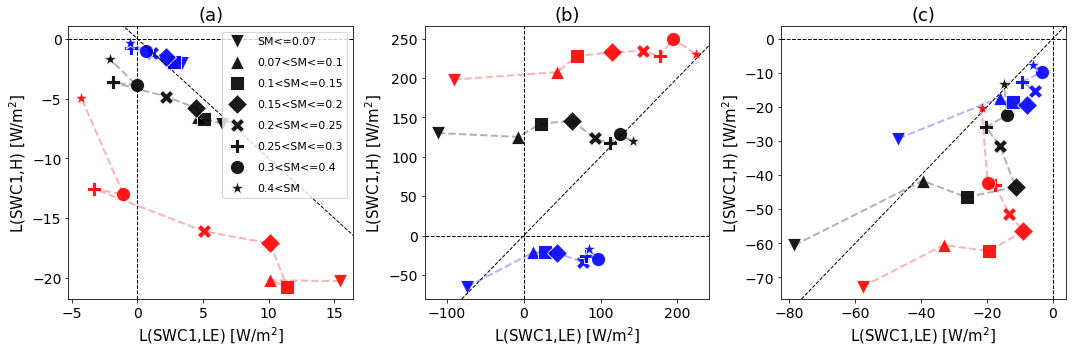

In [48]:
from scipy.stats import skew, skewtest, kurtosis

mv1 = 0
mv2 = 1
mv3 = 10
mv4 = 11

fname="./fig_final/FluxTowers_TCI_smclim_prmask.png"
label1 = ['L(SWC1,LE) [W/m$^2$]','L(SWC1,H) [W/m$^2$]']
label2 = ['A(LE,LCL) [m]','A(H,LCL) [m]']
label3 = ['T(SWC1,LE,LCL) [m]','T(SWC1,H,LCL) [m]']

samp = np.empty([8]) # [vtypes]
sm_lh = np.empty([3,8]) # [times, vtypes]
sm_sh = np.empty([3,8]) # [times, vtypes]
lh_lcl = np.empty([3,8]) # [times, vtypes]
sh_lcl = np.empty([3,8]) # [times, vtypes]
sm_lh_lcl = np.empty([3,8]) # [times, vtypes]
sm_sh_lcl = np.empty([3,8]) # [times, vtypes]
samp[:] = np.nan
sm_lh[:] = np.nan
sm_sh[:] = np.nan
lh_lcl[:] = np.nan
sh_lcl[:] = np.nan
sm_lh_lcl[:] = np.nan
sm_sh_lcl[:] = np.nan

fig = plt.figure(figsize=(15,5))

n = np.array([[23,0,1]]).T
d = np.array([[11,12,13]]).T

veg = ["savannas","shrubland","grassland","cropland","forest","wetland"]
mm = ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())


for v in range(8):
    sm = sv[mv1,:,s,0].flatten()
    if v == 0:
        mm0 = (sm<=7) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm<=7) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm<=7) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    elif v == 1:
        mm0 = (sm>7) & (sm<=10) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm>7) & (sm<=10) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm>7) & (sm<=10) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    elif v == 2:
        mm0 = (sm>10) & (sm<=15) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm>10) & (sm<=15) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm>10) & (sm<=15) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    elif v == 3:
        mm0 = (sm>15) & (sm<=20) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm>15) & (sm<=20) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm>15) & (sm<=20) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    elif v == 4:
        mm0 = (sm>20) & (sm<=25) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm>20) & (sm<=25) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm>20) & (sm<=25) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    elif v == 5:
        mm0 = (sm>25) & (sm<=30) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm>25) & (sm<=30) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm>25) & (sm<=30) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    elif v == 6:
        mm0 = (sm>30) & (sm<=40) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm>30) & (sm<=40) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm>30) & (sm<=40) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    elif v == 7:
        mm0 = (sm>40) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm>40) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm>40) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    
    samp[v] = mm0.sum()
    sm_lh[0,v]     = np.mean(tci[mv1,:,s,0].flatten()[mm0],axis=0)
    sm_lh[1,v]     = np.mean(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()[mm1],axis=0)
    sm_lh[2,v]     = np.mean(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()[mm2],axis=0)
    sm_sh[0,v]     = np.mean(tci[mv2,:,s,0].flatten()[mm0],axis=0)
    sm_sh[1,v]     = np.mean(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()[mm1],axis=0)
    sm_sh[2,v]     = np.mean(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()[mm2],axis=0)
    lh_lcl[0,v]    = np.mean(tci[mv3,:,s,0].flatten()[mm0],axis=0)
    lh_lcl[1,v]    = np.mean(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()[mm1],axis=0)
    lh_lcl[2,v]    = np.mean(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()[mm2],axis=0)
    sh_lcl[0,v]    = np.mean(tci[mv4,:,s,0].flatten()[mm0],axis=0)
    sh_lcl[1,v]    = np.mean(np.nanmean(tci[mv4,:,s,n],axis=0).flatten()[mm1],axis=0)
    sh_lcl[2,v]    = np.mean(np.nanmean(tci[mv4,:,s,d],axis=0).flatten()[mm2],axis=0)
    sm_lh_lcl[0,v] = np.mean(tci[mv3,:,s,0].flatten()[mm0]*tci_r[mv1,:,s,0].flatten()[mm0],axis=0)
    sm_lh_lcl[1,v] = np.mean(np.nanmean(tci[mv3,:,s,n]*tci_r[mv1,:,s,n],axis=0).flatten()[mm1],axis=0)
    sm_lh_lcl[2,v] = np.mean(np.nanmean(tci[mv3,:,s,d]*tci_r[mv1,:,s,d],axis=0).flatten()[mm2],axis=0)
    sm_sh_lcl[0,v] = np.mean(tci[mv4,:,s,0].flatten()[mm0]*tci_r[mv2,:,s,0].flatten()[mm0],axis=0)
    sm_sh_lcl[1,v] = np.mean(np.nanmean(tci[mv4,:,s,n]*tci_r[mv2,:,s,n],axis=0).flatten()[mm1],axis=0)
    sm_sh_lcl[2,v] = np.mean(np.nanmean(tci[mv4,:,s,d]*tci_r[mv2,:,s,d],axis=0).flatten()[mm2],axis=0)


colors = ["black","blue","red"]
markers = ["v","^","s","D","X","P","o","*"]
veg = ["SM<=0.07","0.07<SM<=0.1","0.1<SM<=0.15","0.15<SM<=0.2","0.2<SM<=0.25","0.25<SM<=0.3","0.3<SM<=0.4","0.4<SM"]


ax = fig.add_subplot(131)
for c,col in enumerate(colors):
    for m,mar in enumerate(markers):
        ax.scatter(sm_lh[c,m], sm_sh[c,m], s=200, label=veg[m]+" [{}]".format(samp[v]), facecolors=col, marker=mar, edgecolors='w', alpha=0.9)
        
legends = [xx for x,xx in enumerate(veg)]
ax.legend(legends,fontsize=11 , labelspacing=1., columnspacing=1., loc='upper right')
ax.set_title('(a)',fontsize=18)
ax.tick_params(labelsize=14)
ax.set_xlabel('{}'.format(label1[0]),fontsize=15)
ax.set_ylabel('{}'.format(label1[1]),fontsize=15)
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)
add_identity_r(ax, color='black', linestyle='--',linewidth=1.0)
for c,col in enumerate(colors):
    ax.plot(sm_lh[c,:], sm_sh[c,:],color=col,linestyle='--',linewidth=2.0,alpha=0.3)

    
ax = fig.add_subplot(132)
for c,col in enumerate(colors):
    for m,mar in enumerate(markers):
        ax.scatter(lh_lcl[c,m], sh_lcl[c,m], s=200, label=veg[m], facecolors=col, marker=mar, edgecolors='w', alpha=0.9)
        
ax.set_title('(b)',fontsize=18)
ax.tick_params(labelsize=14)
ax.set_xlabel('{}'.format(label1[0]),fontsize=15)
ax.set_ylabel('{}'.format(label1[1]),fontsize=15)
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)
add_identity(ax, color='black', linestyle='--',linewidth=1.0)
for c,col in enumerate(colors):
    ax.plot(lh_lcl[c,:], sh_lcl[c,:],color=col,linestyle='--',linewidth=2.0,alpha=0.3)
    
ax = fig.add_subplot(133)
for c,col in enumerate(colors):
    for m,mar in enumerate(markers):
        ax.scatter(sm_lh_lcl[c,m], sm_sh_lcl[c,m], s=200, label=veg[m], facecolors=col, marker=mar, edgecolors='w', alpha=0.9)
       
ax.set_title('(c)',fontsize=18)
ax.tick_params(labelsize=14)
ax.set_xlabel('{}'.format(label1[0]),fontsize=15)
ax.set_ylabel('{}'.format(label1[1]),fontsize=15)
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)
add_identity(ax, color='black', linestyle='--',linewidth=1.0)
for c,col in enumerate(colors):
    ax.plot(sm_lh_lcl[c,:], sm_sh_lcl[c,:],color=col,linestyle='--',linewidth=2.0,alpha=0.3)
    
fig.tight_layout()
plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)

plt.show()

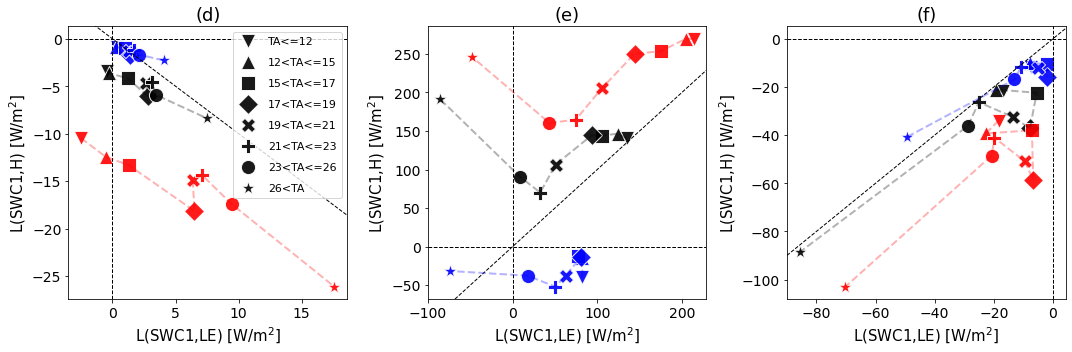

In [49]:
from scipy.stats import skew, skewtest, kurtosis

mv1 = 0
mv2 = 1
mv3 = 10
mv4 = 11

fname="./fig_final/FluxTowers_TCI_taclim_prmask.png"
label1 = ['L(SWC1,LE) [W/m$^2$]','L(SWC1,H) [W/m$^2$]']
label2 = ['A(LE,LCL) [m]','A(H,LCL) [m]']
label3 = ['T(SWC1,LE,LCL) [m]','T(SWC1,H,LCL) [m]']

samp = np.empty([8]) # [vtypes]
sm_lh = np.empty([3,8]) # [times, vtypes]
sm_sh = np.empty([3,8]) # [times, vtypes]
lh_lcl = np.empty([3,8]) # [times, vtypes]
sh_lcl = np.empty([3,8]) # [times, vtypes]
sm_lh_lcl = np.empty([3,8]) # [times, vtypes]
sm_sh_lcl = np.empty([3,8]) # [times, vtypes]
samp[:] = np.nan
sm_lh[:] = np.nan
sm_sh[:] = np.nan
lh_lcl[:] = np.nan
sh_lcl[:] = np.nan
sm_lh_lcl[:] = np.nan
sm_sh_lcl[:] = np.nan

fig = plt.figure(figsize=(15,5))

n = np.array([[23,0,1]]).T
d = np.array([[11,12,13]]).T

veg = ["savannas","shrubland","grassland","cropland","forest","wetland"]
mm = ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())

for v in range(8):
    sm = tv[6,:,s,0].flatten()
    if v == 0:
        mm0 = (sm<=12) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm<=12) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm<=12) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    elif v == 1:
        mm0 = (sm>12) & (sm<=15) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm>12) & (sm<=15) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm>12) & (sm<=15) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    elif v == 2:
        mm0 = (sm>15) & (sm<=17) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm>15) & (sm<=17) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm>15) & (sm<=17) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    elif v == 3:
        mm0 = (sm>17) & (sm<=19) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm>17) & (sm<=19) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm>17) & (sm<=19) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    elif v == 4:
        mm0 = (sm>19) & (sm<=21) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm>19) & (sm<=21) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm>19) & (sm<=21) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    elif v == 5:
        mm0 = (sm>21) & (sm<=23) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm>21) & (sm<=23) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm>21) & (sm<=23) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    elif v == 6:
        mm0 = (sm>23) & (sm<=26) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm>23) & (sm<=26) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm>23) & (sm<=26) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    elif v == 7:
        mm0 = (sm>26) & ~np.isnan(tci[mv1,:,s,0].flatten()) & ~np.isnan(tci[mv2,:,s,0].flatten()) & ~np.isnan(tci[mv3,:,s,0].flatten()) & ~np.isnan(tci[mv4,:,s,0].flatten())
        mm1 = (sm>26) & ~np.isnan(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,n],axis=0).flatten())
        mm2 = (sm>26) & ~np.isnan(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()) & ~np.isnan(np.nanmean(tci[mv4,:,s,d],axis=0).flatten())
    
    samp[v] = mm0.sum()
    sm_lh[0,v]     = np.mean(tci[mv1,:,s,0].flatten()[mm0],axis=0)
    sm_lh[1,v]     = np.mean(np.nanmean(tci[mv1,:,s,n],axis=0).flatten()[mm1],axis=0)
    sm_lh[2,v]     = np.mean(np.nanmean(tci[mv1,:,s,d],axis=0).flatten()[mm2],axis=0)
    sm_sh[0,v]     = np.mean(tci[mv2,:,s,0].flatten()[mm0],axis=0)
    sm_sh[1,v]     = np.mean(np.nanmean(tci[mv2,:,s,n],axis=0).flatten()[mm1],axis=0)
    sm_sh[2,v]     = np.mean(np.nanmean(tci[mv2,:,s,d],axis=0).flatten()[mm2],axis=0)
    lh_lcl[0,v]    = np.mean(tci[mv3,:,s,0].flatten()[mm0],axis=0)
    lh_lcl[1,v]    = np.mean(np.nanmean(tci[mv3,:,s,n],axis=0).flatten()[mm1],axis=0)
    lh_lcl[2,v]    = np.mean(np.nanmean(tci[mv3,:,s,d],axis=0).flatten()[mm2],axis=0)
    sh_lcl[0,v]    = np.mean(tci[mv4,:,s,0].flatten()[mm0],axis=0)
    sh_lcl[1,v]    = np.mean(np.nanmean(tci[mv4,:,s,n],axis=0).flatten()[mm1],axis=0)
    sh_lcl[2,v]    = np.mean(np.nanmean(tci[mv4,:,s,d],axis=0).flatten()[mm2],axis=0)
    # lh_lcl[0,v]    = np.mean(tci_r[mv3,:,s,0].flatten()[mm0],axis=0)
    # lh_lcl[1,v]    = np.mean(np.nanmean(tci_r[mv3,:,s,n],axis=0).flatten()[mm1],axis=0)
    # lh_lcl[2,v]    = np.mean(np.nanmean(tci_r[mv3,:,s,d],axis=0).flatten()[mm2],axis=0)
    # sh_lcl[0,v]    = np.mean(tci_r[mv4,:,s,0].flatten()[mm0],axis=0)
    # sh_lcl[1,v]    = np.mean(np.nanmean(tci_r[mv4,:,s,n],axis=0).flatten()[mm1],axis=0)
    # sh_lcl[2,v]    = np.mean(np.nanmean(tci_r[mv4,:,s,d],axis=0).flatten()[mm2],axis=0)
    sm_lh_lcl[0,v] = np.mean(tci[mv3,:,s,0].flatten()[mm0]*tci_r[mv1,:,s,0].flatten()[mm0],axis=0)
    sm_lh_lcl[1,v] = np.mean(np.nanmean(tci[mv3,:,s,n]*tci_r[mv1,:,s,n],axis=0).flatten()[mm1],axis=0)
    sm_lh_lcl[2,v] = np.mean(np.nanmean(tci[mv3,:,s,d]*tci_r[mv1,:,s,d],axis=0).flatten()[mm2],axis=0)
    sm_sh_lcl[0,v] = np.mean(tci[mv4,:,s,0].flatten()[mm0]*tci_r[mv2,:,s,0].flatten()[mm0],axis=0)
    sm_sh_lcl[1,v] = np.mean(np.nanmean(tci[mv4,:,s,n]*tci_r[mv2,:,s,n],axis=0).flatten()[mm1],axis=0)
    sm_sh_lcl[2,v] = np.mean(np.nanmean(tci[mv4,:,s,d]*tci_r[mv2,:,s,d],axis=0).flatten()[mm2],axis=0)


colors = ["black","blue","red"]
markers = ["v","^","s","D","X","P","o","*"]
veg = ["TA<=12","12<TA<=15","15<TA<=17","17<TA<=19","19<TA<=21","21<TA<=23","23<TA<=26","26<TA"]

ax = fig.add_subplot(131)
for c,col in enumerate(colors):
    for m,mar in enumerate(markers):
        ax.scatter(sm_lh[c,m], sm_sh[c,m], s=200, label=veg[m]+" [{}]".format(samp[v]), facecolors=col, marker=mar, edgecolors='w', alpha=0.9)
        
legends = [xx for x,xx in enumerate(veg)]
ax.legend(legends,fontsize=11 , labelspacing=1., columnspacing=1., loc='upper right')
ax.set_title('(d)',fontsize=18)
ax.tick_params(labelsize=14)
ax.set_xlabel('{}'.format(label1[0]),fontsize=15)
ax.set_ylabel('{}'.format(label1[1]),fontsize=15)
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)
add_identity_r(ax, color='black', linestyle='--',linewidth=1.0)
for c,col in enumerate(colors):
    ax.plot(sm_lh[c,:], sm_sh[c,:],color=col,linestyle='--',linewidth=2.0,alpha=0.3)
    
ax = fig.add_subplot(132)
for c,col in enumerate(colors):
    for m,mar in enumerate(markers):
        ax.scatter(lh_lcl[c,m], sh_lcl[c,m], s=200, label=veg[m], facecolors=col, marker=mar, edgecolors='w', alpha=0.9)
        
ax.set_title('(e)',fontsize=18)
ax.tick_params(labelsize=14)
ax.set_xlabel('{}'.format(label1[0]),fontsize=15)
ax.set_ylabel('{}'.format(label1[1]),fontsize=15)
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)
add_identity(ax, color='black', linestyle='--',linewidth=1.0)
for c,col in enumerate(colors):
    ax.plot(lh_lcl[c,:], sh_lcl[c,:],color=col,linestyle='--',linewidth=2.0,alpha=0.3)

ax = fig.add_subplot(133)
for c,col in enumerate(colors):
    for m,mar in enumerate(markers):
        ax.scatter(sm_lh_lcl[c,m], sm_sh_lcl[c,m], s=200, label=veg[m], facecolors=col, marker=mar, edgecolors='w', alpha=0.9)
        
ax.set_title('(f)',fontsize=18)
ax.tick_params(labelsize=14)
ax.set_xlabel('{}'.format(label1[0]),fontsize=15)
ax.set_ylabel('{}'.format(label1[1]),fontsize=15)
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)
add_identity(ax, color='black', linestyle='--',linewidth=1.0)
for c,col in enumerate(colors):
    ax.plot(sm_lh_lcl[c,:], sm_sh_lcl[c,:],color=col,linestyle='--',linewidth=2.0,alpha=0.3)

fig.tight_layout()
plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

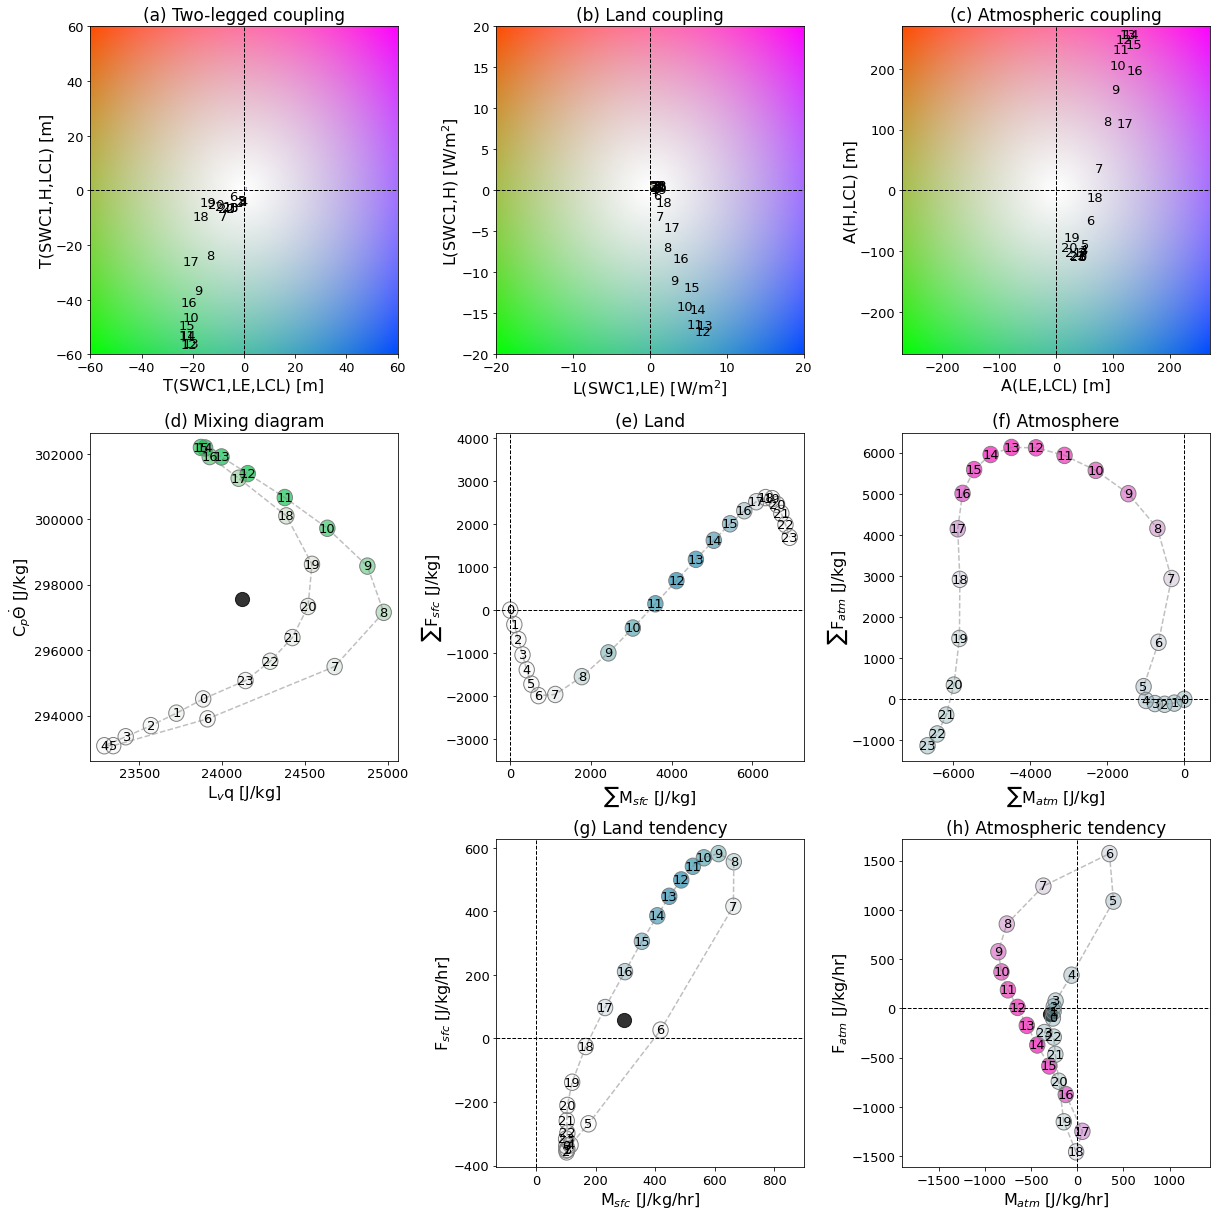

In [50]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import patches

n = np.array([[23,0,1]]).T
d = np.array([[11,12,13]]).T

sea = 0
axis_lim = False
s = season_mon[sea]

xylab = ['L$_v$q [J/kg]', r'C$_p$$\dot{\Theta}$ [J/kg]']
xylab1 = ['∑M$_{sfc}$ [J/kg]', '∑F$_{sfc}$ [J/kg]']
xylab2 = ['∑M$_{atm}$ [J/kg]', '∑F$_{atm}$ [J/kg]']
xylab3 = ['M$_{sfc}$ [J/kg/hr]', 'F$_{sfc}$ [J/kg/hr]']
xylab4 = ['M$_{atm}$ [J/kg/hr]', 'F$_{atm}$ [J/kg/hr]']

mv1 = 0
mv2 = 1
mv3 = 10
mv4 = 11
lim1 = 60
lim2 = 20
lim3 = 270
lst = [x for x in range(24)]

fig = plt.figure(figsize=(17,17))
fname="./fig_final/FluxTowers_mixing_diag_TCI_final.png"
subtitle = ['(a) Two-legged coupling','(b) Land coupling','(c) Atmospheric coupling',
            '(d) Mixing diagram','(e) Land','(f) Atmosphere',
            '(g) Land tendency','(h) Atmospheric tendency']

mm = ~np.isnan(np.nanmean(tci[mv1,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv2,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv3,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv4,:,s,0],axis=0))

ax = fig.add_subplot(331)
cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:]*tci_r[mv1,:,s,1:],axis=0)[mm,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:]*tci_r[mv2,:,s,1:],axis=0)[mm,:],axis=0)

cp1 = np.linspace(0,1, num=200)
cp2 = np.linspace(0,1, num=200)
Cp1, Cp2 = np.meshgrid(cp1,cp2)
CC0 = ( np.sqrt( (Cp1)**2 + (Cp2)**2 ) / np.sqrt(2) )
CC1 = ( CC0 - CC0.min() ) / (CC0.max() - CC0.min())
C0 = -CC1 + 1
Cp4 = np.sqrt( (Cp1-0.5)**2 + (Cp2-0.5)**2 ) *np.sqrt(2) 
CC4 = ( Cp4 - Cp4.min() ) / (Cp4.max() - Cp4.min())

# make RGB image, p1 to red channel, p2 to blue channel
Legend = np.dstack((Cp2, C0, Cp1, CC4))
# parameters range between 0 and 1
ax.imshow(Legend, origin="lower", extent=[0,1,0,1])
ax.tick_params(labelsize=13)
ax.set_xlabel('T(SWC1,LE,LCL) [m]', labelpad = 3,fontsize=16)
ax.set_ylabel('T(SWC1,H,LCL) [m]', labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[0]),fontsize=17)  
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)

xrange = [-lim1,lim1]
yrange = [-lim1,lim1]
ax.imshow(
    Legend,
    extent = (
        xrange[0],xrange[1],
        yrange[0],yrange[1],
    ),
    aspect = 'auto',
    origin = 'lower',
)

for i, txt in enumerate(lst):
    ax.annotate(i, xy=(cc1[i], cc2[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)


ax = fig.add_subplot(332)
cc1 = np.nanmean(np.nanmean(tci[mv1,:,s,1:],axis=0)[mm,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv2,:,s,1:],axis=0)[mm,:],axis=0)

# parameters range between 0 and 1
ax.imshow(Legend, origin="lower", extent=[0,1,0,1])
ax.tick_params(labelsize=13)
ax.set_xlabel('L(SWC1,LE) [W/m$^2$]', labelpad = 3,fontsize=16)
ax.set_ylabel('L(SWC1,H) [W/m$^2$]', labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[1]),fontsize=17)  
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)

xrange = [-lim2,lim2]
yrange = [-lim2,lim2]
ax.imshow(
    Legend,
    extent = (
        xrange[0],xrange[1],
        yrange[0],yrange[1],
    ),
    aspect = 'auto',
    origin = 'lower',
)

for i, txt in enumerate(lst):
    ax.annotate(i, xy=(cc1[i], cc2[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)

    
ax = fig.add_subplot(333)
cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:],axis=0)[mm,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:],axis=0)[mm,:],axis=0)

# parameters range between 0 and 1
ax.imshow(Legend, origin="lower", extent=[0,1,0,1])
ax.tick_params(labelsize=13)
ax.set_xlabel('A(LE,LCL) [m]', labelpad = 3,fontsize=16)
ax.set_ylabel('A(H,LCL) [m]', labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[2]),fontsize=17)  
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)

xrange = [-lim3,lim3]
yrange = [-lim3,lim3]
ax.imshow(
    Legend,
    extent = (
        xrange[0],xrange[1],
        yrange[0],yrange[1],
    ),
    aspect = 'auto',
    origin = 'lower',
)

for i, txt in enumerate(lst):
    ax.annotate(i, xy=(cc1[i], cc2[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)


ax = fig.add_subplot(334)
x1, y1 = np.nanmean(np.nanmean(loco_q[:,s,1:][mm,:,:],axis=1),axis=0), np.nanmean(np.nanmean(loco_t[:,s,1:][mm,:,:],axis=1),axis=0)
xx2, yy2 = np.nanmean(x1), np.nanmean(y1)

cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:]*tci_r[mv1,:,s,1:],axis=0)[mm,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:]*tci_r[mv2,:,s,1:],axis=0)[mm,:],axis=0)

ccc1 = (cc1 + lim1) / (lim1*2)
ccc2 = (cc2 + lim1) / (lim1*2)
cc0 = ( np.sqrt( (cc1+lim1)**2 + (cc2+lim1)**2 ) / np.sqrt(2) / (lim1*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim1
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

ax.plot(x1,y1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.plot([x1[len(x1)-1], x1[0]],[y1[len(y1)-1], y1[0]],color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.scatter(xx2, yy2, s=200, marker='o', facecolors='black', edgecolors='black', alpha=0.8)
y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
x_mean = (x_min + x_max) * 0.5
y_mean = (y_min + y_max) * 0.5
axr = np.array([x_max-x_min, y_max-y_min]).max()
for i, txt in enumerate(lst):
    circle = patches.Ellipse((x1[i], y1[i]), (x_max-x_min)*0.05, (y_max-y_min)*0.05, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]), edgecolor='gray')
    ax.add_patch(circle)
    ax.annotate(i, xy=(x1[i], y1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)

# ax.scatter(xx1, yy1, s=200, marker='*', facecolors='none', edgecolors='black', alpha=0.8)
ax.tick_params(labelsize=13)
ax.set_xlabel(xylab[0], labelpad = 3,fontsize=16)
ax.set_ylabel(xylab[1], labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[3]),fontsize=17)    



me_sfc = loco_lh[mm,:,:][:,s,1:] / ( loco_den[mm,:,:][:,s,1:]*loco_pbl[mm,:,:][:,s,1:] ) * 3600.
te_sfc = loco_sh[mm,:,:][:,s,1:] / ( loco_den[mm,:,:][:,s,1:]*loco_pbl[mm,:,:][:,s,1:] ) * 3600.

me_atm = np.empty(me_sfc.shape)
te_atm = np.empty(me_sfc.shape)
me_atm[:] = np.nan
te_atm[:] = np.nan

for x in range(24):
    if x == 23:
        me_atm[:,:,x] = loco_q[mm,:,:][:,s,1] - loco_q[mm,:,:][:,s,x+1] - (loco_lh[mm,:,:][:,s,x+1] / ( loco_den[mm,:,:][:,s,x+1]*loco_pbl[mm,:,:][:,s,x+1] ) * 3600.) 
        te_atm[:,:,x] = loco_t[mm,:,:][:,s,1] - loco_t[mm,:,:][:,s,x+1] - (loco_sh[mm,:,:][:,s,x+1] / ( loco_den[mm,:,:][:,s,x+1]*loco_pbl[mm,:,:][:,s,x+1] ) * 3600.) 
    else:
        me_atm[:,:,x] = loco_q[mm,:,:][:,s,x+2] - loco_q[mm,:,:][:,s,x+1] - (loco_lh[mm,:,:][:,s,x+1] / ( loco_den[mm,:,:][:,s,x+1]*loco_pbl[mm,:,:][:,s,x+1] ) * 3600.)
        te_atm[:,:,x] = loco_t[mm,:,:][:,s,x+2] - loco_t[mm,:,:][:,s,x+1] - (loco_sh[mm,:,:][:,s,x+1] / ( loco_den[mm,:,:][:,s,x+1]*loco_pbl[mm,:,:][:,s,x+1] ) * 3600.)
            

ax = fig.add_subplot(335)
xx1 = np.empty(me_sfc.shape)
yy1 = np.empty(me_sfc.shape)
xx1[:] = np.nan
yy1[:] = np.nan

for x in range(24):
    xx1[:,:,x] = np.nansum(me_sfc[:,:,:x],axis=2)
    yy1[:,:,x] = np.nansum(te_sfc[:,:,:x],axis=2)
    
x1 = np.nanmean(np.nanmean(xx1,axis=1),axis=0)
y1 = np.nanmean(np.nanmean(yy1,axis=1),axis=0)
xx2, yy2 = np.nanmean(x1), np.nanmean(y1)

cc1 = np.nanmean(np.nanmean(tci[mv1,:,s,1:],axis=0)[mm,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv2,:,s,1:],axis=0)[mm,:],axis=0)

ccc1 = (cc1 + lim2) / (lim2*2)
ccc2 = (cc2 + lim2) / (lim2*2)
cc0 = ( np.sqrt( (cc1+lim2)**2 + (cc2+lim2)**2 ) / np.sqrt(2) / (lim2*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim2
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

ax.plot(x1,y1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)

y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
x_mean = (x_min + x_max) * 0.5
y_mean = (y_min + y_max) * 0.5
axr = np.array([x_max-x_min, y_max-y_min]).max()
for i, txt in enumerate(lst):
    circle = patches.Ellipse((x1[i], y1[i]), axr*0.05, axr*0.05, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]), edgecolor='gray')
    ax.add_patch(circle)
    ax.annotate(i, xy=(x1[i], y1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)

ax.tick_params(labelsize=13)
ax.set_xlabel(xylab1[0], labelpad = 3,fontsize=16)
ax.set_ylabel(xylab1[1], labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[4]),fontsize=17)    
y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
x_mean = (x_min + x_max) * 0.5
y_mean = (y_min + y_max) * 0.5
axr = np.array([x_max-x_min, y_max-y_min]).max()
ax.set_xlim([x_mean-axr*0.5, x_mean+axr*0.5])
ax.set_ylim([y_mean-axr*0.5, y_mean+axr*0.5])
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)


    
ax = fig.add_subplot(336)
xx1 = np.empty(me_sfc.shape)
yy1 = np.empty(me_sfc.shape)
xx1[:] = np.nan
yy1[:] = np.nan

for x in range(24):
    xx1[:,:,x] = np.nansum(me_atm[:,:,:x],axis=2)
    yy1[:,:,x] = np.nansum(te_atm[:,:,:x],axis=2)
    
x1 = np.nanmean(np.nanmean(xx1,axis=1),axis=0)
y1 = np.nanmean(np.nanmean(yy1,axis=1),axis=0)
xx2, yy2 = np.nanmean(x1), np.nanmean(y1)

cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:],axis=0)[mm,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:],axis=0)[mm,:],axis=0)

ccc1 = (cc1 + lim3) / (lim3*2)
ccc2 = (cc2 + lim3) / (lim3*2)
cc0 = ( np.sqrt( (cc1+lim3)**2 + (cc2+lim3)**2 ) / np.sqrt(2) / (lim3*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim3
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

ax.plot(x1,y1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)

y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
x_mean = (x_min + x_max) * 0.5
y_mean = (y_min + y_max) * 0.5
axr = np.array([x_max-x_min, y_max-y_min]).max()
for i, txt in enumerate(lst):
    circle = patches.Ellipse((x1[i], y1[i]), axr*0.05, axr*0.05, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]), edgecolor='gray')
    ax.add_patch(circle)
    ax.annotate(i, xy=(x1[i], y1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)

ax.tick_params(labelsize=13)
ax.set_xlabel(xylab2[0], labelpad = 3,fontsize=16)
ax.set_ylabel(xylab2[1], labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[5]),fontsize=17)    
y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
x_mean = (x_min + x_max) * 0.5
y_mean = (y_min + y_max) * 0.5
axr = np.array([x_max-x_min, y_max-y_min]).max()
ax.set_xlim([x_mean-axr*0.5, x_mean+axr*0.5])
ax.set_ylim([y_mean-axr*0.5, y_mean+axr*0.5])
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)


    
ax = fig.add_subplot(338)
for x in range(24):
    xx1[:,:,x] = np.nansum(me_sfc[:,:,:x],axis=2)
    yy1[:,:,x] = np.nansum(te_sfc[:,:,:x],axis=2)
    
x1 = np.nanmean(np.nanmean(me_sfc,axis=1),axis=0)
y1 = np.nanmean(np.nanmean(te_sfc,axis=1),axis=0)
xx2, yy2 = np.nanmean(x1), np.nanmean(y1)

cc1 = np.nanmean(np.nanmean(tci[mv1,:,s,1:],axis=0)[mm,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv2,:,s,1:],axis=0)[mm,:],axis=0)

ccc1 = (cc1 + lim2) / (lim2*2)
ccc2 = (cc2 + lim2) / (lim2*2)
cc0 = ( np.sqrt( (cc1+lim2)**2 + (cc2+lim2)**2 ) / np.sqrt(2) / (lim2*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim2
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

ax.plot(x1,y1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.plot([x1[len(x1)-1], x1[0]],[y1[len(y1)-1], y1[0]],color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.scatter(xx2, yy2, s=200, marker='o', facecolors='black', edgecolors='black', alpha=0.8)

y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
x_mean = (x_min + x_max) * 0.5
y_mean = (y_min + y_max) * 0.5
axr = np.array([x_max-x_min, y_max-y_min]).max()
for i, txt in enumerate(lst):
    circle = patches.Ellipse((x1[i], y1[i]), axr*0.05, axr*0.05, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]), edgecolor='gray')
    ax.add_patch(circle)
    ax.annotate(i, xy=(x1[i], y1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)

ax.tick_params(labelsize=13)
ax.set_xlabel(xylab3[0], labelpad = 3,fontsize=16)
ax.set_ylabel(xylab3[1], labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[6]),fontsize=17)    
y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
x_mean = (x_min + x_max) * 0.5
y_mean = (y_min + y_max) * 0.5
axr = np.array([x_max-x_min, y_max-y_min]).max()
ax.set_xlim([x_mean-axr*0.5, x_mean+axr*0.5])
ax.set_ylim([y_mean-axr*0.5, y_mean+axr*0.5])
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)



ax = fig.add_subplot(339)
for x in range(24):
    xx1[:,:,x] = np.nansum(me_atm[:,:,:x],axis=2)
    yy1[:,:,x] = np.nansum(te_atm[:,:,:x],axis=2)
    
x1 = np.nanmean(np.nanmean(me_atm,axis=1),axis=0)
y1 = np.nanmean(np.nanmean(te_atm,axis=1),axis=0)
xx2, yy2 = np.nanmean(x1), np.nanmean(y1)

cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:],axis=0)[mm,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:],axis=0)[mm,:],axis=0)

ccc1 = (cc1 + lim3) / (lim3*2)
ccc2 = (cc2 + lim3) / (lim3*2)
cc0 = ( np.sqrt( (cc1+lim3)**2 + (cc2+lim3)**2 ) / np.sqrt(2) / (lim3*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim3
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

ax.plot(x1,y1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.plot([x1[len(x1)-1], x1[0]],[y1[len(y1)-1], y1[0]],color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.scatter(xx2, yy2, s=200, marker='o', facecolors='black', edgecolors='black', alpha=0.8)

y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
x_mean = (x_min + x_max) * 0.5
y_mean = (y_min + y_max) * 0.5
axr = np.array([x_max-x_min, y_max-y_min]).max()
for i, txt in enumerate(lst):
    circle = patches.Ellipse((x1[i], y1[i]), axr*0.05, axr*0.05, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]), edgecolor='gray')
    ax.add_patch(circle)
    ax.annotate(i, xy=(x1[i], y1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)

ax.tick_params(labelsize=13)
ax.set_xlabel(xylab4[0], labelpad = 3,fontsize=16)
ax.set_ylabel(xylab4[1], labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[7]),fontsize=17)    
y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
x_mean = (x_min + x_max) * 0.5
y_mean = (y_min + y_max) * 0.5
axr = np.array([x_max-x_min, y_max-y_min]).max()
ax.set_xlim([x_mean-axr*0.5, x_mean+axr*0.5])
ax.set_ylim([y_mean-axr*0.5, y_mean+axr*0.5])
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)

fig.tight_layout()
plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

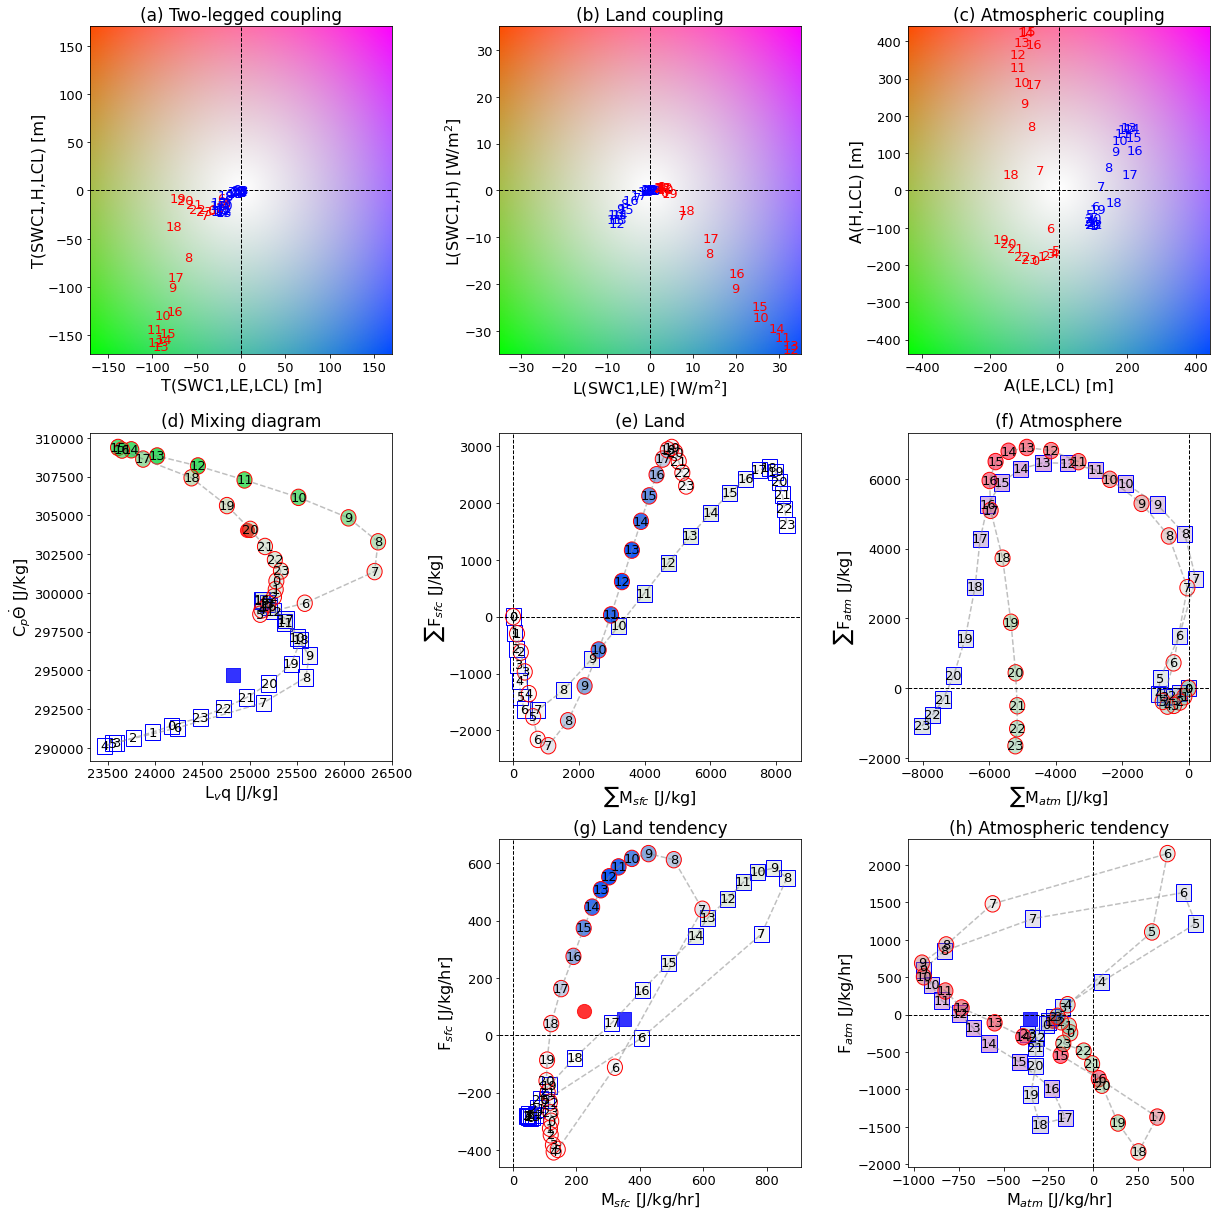

In [51]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import patches

n = np.array([[23,0,1]]).T
d = np.array([[11,12,13]]).T

sea = 0
axis_lim = False
s = season_mon[sea]

xylab = ['L$_v$q [J/kg]', r'C$_p$$\dot{\Theta}$ [J/kg]']
xylab3 = ['M$_{sfc}$ [J/kg/hr]', 'F$_{sfc}$ [J/kg/hr]']
xylab4 = ['M$_{atm}$ [J/kg/hr]', 'F$_{atm}$ [J/kg/hr]']
xylab1 = ['∑M$_{sfc}$ [J/kg]', '∑F$_{sfc}$ [J/kg]']
xylab2 = ['∑M$_{atm}$ [J/kg]', '∑F$_{atm}$ [J/kg]']

mv1 = 0
mv2 = 1
mv3 = 10
mv4 = 11
lim1 = 170
lim2 = 35
lim3 = 440
lst = [x for x in range(24)]

fig = plt.figure(figsize=(17,17))
fname="./fig_final/FluxTowers_mixing_diag_TCI_climate.png"
subtitle = ['(a) Two-legged coupling','(b) Land coupling','(c) Atmospheric coupling',
            '(d) Mixing diagram','(e) Land','(f) Atmosphere',
            '(g) Land tendency','(h) Atmospheric tendency']

mm1 = ( np.array(igbp) != 'SAV' ) & ( np.nanmean(tci_p[2,:,s,0],axis=0)<0.14 ) & ( np.nanmean(tci_r[2,:,s,0],axis=0)<0.08 ) & ~np.isnan(np.nanmean(tci[mv1,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv2,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv3,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv4,:,s,0],axis=0))
mm2 = ( np.nanmean(tci_p[2,:,s,0],axis=0)<0.005 ) & ( np.nanmean(tci_r[2,:,s,0],axis=0)>0.36 ) & ~np.isnan(np.nanmean(tci[mv1,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv2,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv3,:,s,0],axis=0)) & ~np.isnan(np.nanmean(tci[mv4,:,s,0],axis=0))

ax = fig.add_subplot(331)
cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:]*tci_r[mv1,:,s,1:],axis=0)[mm1,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:]*tci_r[mv2,:,s,1:],axis=0)[mm1,:],axis=0)

dd1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:]*tci_r[mv1,:,s,1:],axis=0)[mm2,:],axis=0)
dd2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:]*tci_r[mv2,:,s,1:],axis=0)[mm2,:],axis=0)

cp1 = np.linspace(0,1, num=200)
cp2 = np.linspace(0,1, num=200)
Cp1, Cp2 = np.meshgrid(cp1,cp2)
CC0 = ( np.sqrt( (Cp1)**2 + (Cp2)**2 ) / np.sqrt(2) )
CC1 = ( CC0 - CC0.min() ) / (CC0.max() - CC0.min())
C0 = -CC1 + 1
Cp4 = np.sqrt( (Cp1-0.5)**2 + (Cp2-0.5)**2 ) *np.sqrt(2) 
CC4 = ( Cp4 - Cp4.min() ) / (Cp4.max() - Cp4.min())

# make RGB image, p1 to red channel, p2 to blue channel
Legend = np.dstack((Cp2, C0, Cp1, CC4))
# parameters range between 0 and 1
ax.imshow(Legend, origin="lower", extent=[0,1,0,1])
ax.tick_params(labelsize=13)
ax.set_xlabel('T(SWC1,LE,LCL) [m]', labelpad = 3,fontsize=16)
ax.set_ylabel('T(SWC1,H,LCL) [m]', labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[0]),fontsize=17)  
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)

xrange = [-lim1,lim1]
yrange = [-lim1,lim1]
ax.imshow(
    Legend,
    extent = (
        xrange[0],xrange[1],
        yrange[0],yrange[1],
    ),
    aspect = 'auto',
    origin = 'lower',
)


for i, txt in enumerate(lst):
    ax.annotate(i, xy=(cc1[i], cc2[i]), xycoords='data', color='blue', textcoords='data', ha='center', va="center", fontsize=13)
    ax.annotate(i, xy=(dd1[i], dd2[i]), xycoords='data', color='red', textcoords='data', ha='center', va="center", fontsize=13)



ax = fig.add_subplot(332)
cc1 = np.nanmean(np.nanmean(tci[mv1,:,s,1:],axis=0)[mm1,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv2,:,s,1:],axis=0)[mm1,:],axis=0)
dd1 = np.nanmean(np.nanmean(tci[mv1,:,s,1:],axis=0)[mm2,:],axis=0)
dd2 = np.nanmean(np.nanmean(tci[mv2,:,s,1:],axis=0)[mm2,:],axis=0)

# parameters range between 0 and 1
ax.imshow(Legend, origin="lower", extent=[0,1,0,1])
ax.tick_params(labelsize=13)
ax.set_xlabel('L(SWC1,LE) [W/m$^2$]', labelpad = 3,fontsize=16)
ax.set_ylabel('L(SWC1,H) [W/m$^2$]', labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[1]),fontsize=17)  
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)

xrange = [-lim2,lim2]
yrange = [-lim2,lim2]
ax.imshow(
    Legend,
    extent = (
        xrange[0],xrange[1],
        yrange[0],yrange[1],
    ),
    aspect = 'auto',
    origin = 'lower',
)

for i, txt in enumerate(lst):
    ax.annotate(i, xy=(cc1[i], cc2[i]), xycoords='data', color='blue', textcoords='data', ha='center', va="center", fontsize=13)
    ax.annotate(i, xy=(dd1[i], dd2[i]), xycoords='data', color='red', textcoords='data', ha='center', va="center", fontsize=13)

    
ax = fig.add_subplot(333)
cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:],axis=0)[mm1,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:],axis=0)[mm1,:],axis=0)
dd1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:],axis=0)[mm2,:],axis=0)
dd2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:],axis=0)[mm2,:],axis=0)

# parameters range between 0 and 1
ax.imshow(Legend, origin="lower", extent=[0,1,0,1])
ax.tick_params(labelsize=13)
ax.set_xlabel('A(LE,LCL) [m]', labelpad = 3,fontsize=16)
ax.set_ylabel('A(H,LCL) [m]', labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[2]),fontsize=17)  
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)

xrange = [-lim3,lim3]
yrange = [-lim3,lim3]
ax.imshow(
    Legend,
    extent = (
        xrange[0],xrange[1],
        yrange[0],yrange[1],
    ),
    aspect = 'auto',
    origin = 'lower',
)

# ax.scatter(cc1,cc2, s=300, marker='o', facecolors='none', edgecolors='black')

for i, txt in enumerate(lst):
    ax.annotate(i, xy=(cc1[i], cc2[i]), xycoords='data', color='blue', textcoords='data', ha='center', va="center", fontsize=13)
    ax.annotate(i, xy=(dd1[i], dd2[i]), xycoords='data', color='red', textcoords='data', ha='center', va="center", fontsize=13)
    


ax = fig.add_subplot(334)
x1, y1 = np.nanmean(np.nanmean(loco_q[:,s,1:][mm1,:,:],axis=1),axis=0), np.nanmean(np.nanmean(loco_t[:,s,1:][mm1,:,:],axis=1),axis=0)
xx2, yy2 = np.nanmean(x1), np.nanmean(y1)
z1, v1 = np.nanmean(np.nanmean(loco_q[:,s,1:][mm2,:,:],axis=1),axis=0), np.nanmean(np.nanmean(loco_t[:,s,1:][mm2,:,:],axis=1),axis=0)
zz2, vv2 = np.nanmean(z1), np.nanmean(v1)

ax.plot(x1,y1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.plot([x1[len(x1)-1], x1[0]],[y1[len(y1)-1], y1[0]],color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.scatter(xx2, yy2, s=200, marker='s', facecolors='blue', edgecolors='blue', alpha=0.8)

ax.plot(z1,v1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.plot([z1[len(x1)-1], z1[0]],[v1[len(y1)-1], v1[0]],color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.scatter(zz2, vv2, s=200, marker='o', facecolors='red', edgecolors='red', alpha=0.8)

y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
x_mean = (x_min + x_max) * 0.5
y_mean = (y_min + y_max) * 0.5
axr = np.array([x_max-x_min, y_max-y_min]).max()

cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:]*tci_r[mv1,:,s,1:],axis=0)[mm1,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:]*tci_r[mv2,:,s,1:],axis=0)[mm1,:],axis=0)
ccc1 = (cc1 + lim1) / (lim1*2)
ccc2 = (cc2 + lim1) / (lim1*2)
cc0 = ( np.sqrt( (cc1+lim1)**2 + (cc2+lim1)**2 ) / np.sqrt(2) / (lim1*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim1
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

for i, txt in enumerate(lst):
    circle = patches.Rectangle((x1[i]-(x_max-x_min)*0.05/2, y1[i]-(y_max-y_min)*0.05/2), (x_max-x_min)*0.05, (y_max-y_min)*0.05, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]), edgecolor='blue')
    ax.add_patch(circle)
    ax.annotate(i, xy=(x1[i], y1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)


cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:]*tci_r[mv1,:,s,1:],axis=0)[mm2,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:]*tci_r[mv2,:,s,1:],axis=0)[mm2,:],axis=0)
ccc1 = (cc1 + lim1) / (lim1*2)
ccc2 = (cc2 + lim1) / (lim1*2)
cc0 = ( np.sqrt( (cc1+lim1)**2 + (cc2+lim1)**2 ) / np.sqrt(2) / (lim1*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim1
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)


for i, txt in enumerate(lst):
    circle = patches.Ellipse((z1[i], v1[i]), (x_max-x_min)*0.05, (y_max-y_min)*0.05, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]), edgecolor='red')
    ax.add_patch(circle)
    ax.annotate(i, xy=(z1[i], v1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)

ax.tick_params(labelsize=13)
ax.set_xlabel(xylab[0], labelpad = 3,fontsize=16)
ax.set_ylabel(xylab[1], labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[3]),fontsize=17)      



me_sfc1 = loco_lh[mm1,:,:][:,s,1:] / ( loco_den[mm1,:,:][:,s,1:]*loco_pbl[mm1,:,:][:,s,1:] ) * 3600.
te_sfc1 = loco_sh[mm1,:,:][:,s,1:] / ( loco_den[mm1,:,:][:,s,1:]*loco_pbl[mm1,:,:][:,s,1:] ) * 3600.
me_sfc2 = loco_lh[mm2,:,:][:,s,1:] / ( loco_den[mm2,:,:][:,s,1:]*loco_pbl[mm2,:,:][:,s,1:] ) * 3600.
te_sfc2 = loco_sh[mm2,:,:][:,s,1:] / ( loco_den[mm2,:,:][:,s,1:]*loco_pbl[mm2,:,:][:,s,1:] ) * 3600.

me_atm1 = np.empty(me_sfc1.shape)
te_atm1 = np.empty(me_sfc1.shape)
me_atm2 = np.empty(me_sfc1.shape)
te_atm2 = np.empty(me_sfc1.shape)
me_atm1[:] = np.nan
te_atm1[:] = np.nan
me_atm2[:] = np.nan
te_atm2[:] = np.nan

for x in range(24):
    if x == 23:
        me_atm1[:,:,x] = loco_q[mm1,:,:][:,s,1] - loco_q[mm1,:,:][:,s,x+1] - (loco_lh[mm1,:,:][:,s,x+1] / ( loco_den[mm1,:,:][:,s,x+1]*loco_pbl[mm1,:,:][:,s,x+1] ) * 3600.) 
        te_atm1[:,:,x] = loco_t[mm1,:,:][:,s,1] - loco_t[mm1,:,:][:,s,x+1] - (loco_sh[mm1,:,:][:,s,x+1] / ( loco_den[mm1,:,:][:,s,x+1]*loco_pbl[mm1,:,:][:,s,x+1] ) * 3600.) 
        me_atm2[:,:,x] = loco_q[mm2,:,:][:,s,1] - loco_q[mm2,:,:][:,s,x+1] - (loco_lh[mm2,:,:][:,s,x+1] / ( loco_den[mm2,:,:][:,s,x+1]*loco_pbl[mm2,:,:][:,s,x+1] ) * 3600.) 
        te_atm2[:,:,x] = loco_t[mm2,:,:][:,s,1] - loco_t[mm2,:,:][:,s,x+1] - (loco_sh[mm2,:,:][:,s,x+1] / ( loco_den[mm2,:,:][:,s,x+1]*loco_pbl[mm2,:,:][:,s,x+1] ) * 3600.) 
    else:
        me_atm1[:,:,x] = loco_q[mm1,:,:][:,s,x+2] - loco_q[mm1,:,:][:,s,x+1] - (loco_lh[mm1,:,:][:,s,x+1] / ( loco_den[mm1,:,:][:,s,x+1]*loco_pbl[mm1,:,:][:,s,x+1] ) * 3600.)
        te_atm1[:,:,x] = loco_t[mm1,:,:][:,s,x+2] - loco_t[mm1,:,:][:,s,x+1] - (loco_sh[mm1,:,:][:,s,x+1] / ( loco_den[mm1,:,:][:,s,x+1]*loco_pbl[mm1,:,:][:,s,x+1] ) * 3600.)
        me_atm2[:,:,x] = loco_q[mm2,:,:][:,s,x+2] - loco_q[mm2,:,:][:,s,x+1] - (loco_lh[mm2,:,:][:,s,x+1] / ( loco_den[mm2,:,:][:,s,x+1]*loco_pbl[mm2,:,:][:,s,x+1] ) * 3600.)
        te_atm2[:,:,x] = loco_t[mm2,:,:][:,s,x+2] - loco_t[mm2,:,:][:,s,x+1] - (loco_sh[mm2,:,:][:,s,x+1] / ( loco_den[mm2,:,:][:,s,x+1]*loco_pbl[mm2,:,:][:,s,x+1] ) * 3600.)
        
            

ax = fig.add_subplot(335)
xx1 = np.empty(me_sfc1.shape)
yy1 = np.empty(me_sfc1.shape)
xx1[:] = np.nan
yy1[:] = np.nan
xx2 = np.empty(me_sfc1.shape)
yy2 = np.empty(me_sfc1.shape)
xx2[:] = np.nan
yy2[:] = np.nan

for x in range(24):
    xx1[:,:,x] = np.nansum(me_sfc1[:,:,:x],axis=2)
    yy1[:,:,x] = np.nansum(te_sfc1[:,:,:x],axis=2)
    xx2[:,:,x] = np.nansum(me_sfc2[:,:,:x],axis=2)
    yy2[:,:,x] = np.nansum(te_sfc2[:,:,:x],axis=2)
    
    
x1 = np.nanmean(np.nanmean(xx1,axis=1),axis=0)
y1 = np.nanmean(np.nanmean(yy1,axis=1),axis=0)
z1 = np.nanmean(np.nanmean(xx2,axis=1),axis=0)
v1 = np.nanmean(np.nanmean(yy2,axis=1),axis=0)
xx2, yy2 = np.nanmean(x1), np.nanmean(y1)
zz2, vv2 = np.nanmean(z1), np.nanmean(v1)


ax.plot(x1,y1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.plot(z1,v1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)

y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
x_mean = (x_min + x_max) * 0.5
y_mean = (y_min + y_max) * 0.5
axr = np.array([x_max-x_min, y_max-y_min]).max()

cc1 = np.nanmean(np.nanmean(tci[mv1,:,s,1:],axis=0)[mm1,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv2,:,s,1:],axis=0)[mm1,:],axis=0)
ccc1 = (cc1 + lim2) / (lim2*2)
ccc2 = (cc2 + lim2) / (lim2*2)
cc0 = ( np.sqrt( (cc1+lim2)**2 + (cc2+lim2)**2 ) / np.sqrt(2) / (lim2*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim2
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

for i, txt in enumerate(lst):
    circle = patches.Rectangle((x1[i]-(x_max-x_min)*0.05/2, y1[i]-(y_max-y_min)*0.05/2), (x_max-x_min)*0.05, (y_max-y_min)*0.05, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]), edgecolor='blue')
    ax.add_patch(circle)
    ax.annotate(i, xy=(x1[i], y1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)


cc1 = np.nanmean(np.nanmean(tci[mv1,:,s,1:],axis=0)[mm2,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv2,:,s,1:],axis=0)[mm2,:],axis=0)
ccc1 = (cc1 + lim2) / (lim2*2)
ccc2 = (cc2 + lim2) / (lim2*2)
cc0 = ( np.sqrt( (cc1+lim2)**2 + (cc2+lim2)**2 ) / np.sqrt(2) / (lim2*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim2
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

for i, txt in enumerate(lst):
    circle = patches.Ellipse((z1[i], v1[i]), (x_max-x_min)*0.05, (y_max-y_min)*0.05, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]), edgecolor='red')
    ax.add_patch(circle)
    ax.annotate(i, xy=(z1[i], v1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)

    
ax.tick_params(labelsize=13)
ax.set_xlabel(xylab1[0], labelpad = 3,fontsize=16)
ax.set_ylabel(xylab1[1], labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[4]),fontsize=17)   



    
ax = fig.add_subplot(336)
xx1 = np.empty(me_sfc1.shape)
yy1 = np.empty(me_sfc1.shape)
xx1[:] = np.nan
yy1[:] = np.nan
xx2 = np.empty(me_sfc1.shape)
yy2 = np.empty(me_sfc1.shape)
xx2[:] = np.nan
yy2[:] = np.nan

for x in range(24):
    xx1[:,:,x] = np.nansum(me_atm1[:,:,:x],axis=2)
    yy1[:,:,x] = np.nansum(te_atm1[:,:,:x],axis=2)
    xx2[:,:,x] = np.nansum(me_atm2[:,:,:x],axis=2)
    yy2[:,:,x] = np.nansum(te_atm2[:,:,:x],axis=2)
    
    
x1 = np.nanmean(np.nanmean(xx1,axis=1),axis=0)
y1 = np.nanmean(np.nanmean(yy1,axis=1),axis=0)
z1 = np.nanmean(np.nanmean(xx2,axis=1),axis=0)
v1 = np.nanmean(np.nanmean(yy2,axis=1),axis=0)
xx2, yy2 = np.nanmean(x1), np.nanmean(y1)
zz2, vv2 = np.nanmean(z1), np.nanmean(v1)


ax.plot(x1,y1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.plot(z1,v1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)

y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
x_mean = (x_min + x_max) * 0.5
y_mean = (y_min + y_max) * 0.5
axr = np.array([x_max-x_min, y_max-y_min]).max()

cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:],axis=0)[mm1,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:],axis=0)[mm1,:],axis=0)
ccc1 = (cc1 + lim3) / (lim3*2)
ccc2 = (cc2 + lim3) / (lim3*2)
cc0 = ( np.sqrt( (cc1+lim3)**2 + (cc2+lim3)**2 ) / np.sqrt(2) / (lim3*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim3
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

for i, txt in enumerate(lst):
    circle = patches.Rectangle((x1[i]-(x_max-x_min)*0.05/2, y1[i]-(y_max-y_min)*0.05/2), (x_max-x_min)*0.05, (y_max-y_min)*0.05, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]), edgecolor='blue')
    ax.add_patch(circle)
    ax.annotate(i, xy=(x1[i], y1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)


cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:],axis=0)[mm2,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:],axis=0)[mm2,:],axis=0)
ccc1 = (cc1 + lim3) / (lim3*2)
ccc2 = (cc2 + lim3) / (lim3*2)
cc0 = ( np.sqrt( (cc1+lim3)**2 + (cc2+lim3)**2 ) / np.sqrt(2) / (lim3*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim3
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

for i, txt in enumerate(lst):
    circle = patches.Ellipse((z1[i], v1[i]), (x_max-x_min)*0.05, (y_max-y_min)*0.05, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]), edgecolor='red')
    ax.add_patch(circle)
    ax.annotate(i, xy=(z1[i], v1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)


ax.tick_params(labelsize=13)
ax.set_xlabel(xylab2[0], labelpad = 3,fontsize=16)
ax.set_ylabel(xylab2[1], labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[5]),fontsize=17)    


    
ax = fig.add_subplot(338)
xx1 = np.empty(me_sfc1.shape)
yy1 = np.empty(me_sfc1.shape)
xx1[:] = np.nan
yy1[:] = np.nan
xx2 = np.empty(me_sfc1.shape)
yy2 = np.empty(me_sfc1.shape)
xx2[:] = np.nan
yy2[:] = np.nan
for x in range(24):
    xx1[:,:,x] = np.nansum(me_sfc1[:,:,:x],axis=2)
    yy1[:,:,x] = np.nansum(te_sfc1[:,:,:x],axis=2)
    xx2[:,:,x] = np.nansum(me_sfc2[:,:,:x],axis=2)
    yy2[:,:,x] = np.nansum(te_sfc2[:,:,:x],axis=2)
    
    
x1 = np.nanmean(np.nanmean(me_sfc1,axis=1),axis=0)
y1 = np.nanmean(np.nanmean(te_sfc1,axis=1),axis=0)
z1 = np.nanmean(np.nanmean(me_sfc2,axis=1),axis=0)
v1 = np.nanmean(np.nanmean(te_sfc2,axis=1),axis=0)
xx2, yy2 = np.nanmean(x1), np.nanmean(y1)
zz2, vv2 = np.nanmean(z1), np.nanmean(v1)


ax.plot(x1,y1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.plot([x1[len(x1)-1], x1[0]],[y1[len(y1)-1], y1[0]],color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.scatter(xx2, yy2, s=200, marker='s', facecolors='blue', edgecolors='blue', alpha=0.8)

ax.plot(z1,v1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.plot([z1[len(x1)-1], z1[0]],[v1[len(y1)-1], v1[0]],color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.scatter(zz2, vv2, s=200, marker='o', facecolors='red', edgecolors='red', alpha=0.8)
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)

y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
x_mean = (x_min + x_max) * 0.5
y_mean = (y_min + y_max) * 0.5
axr = np.array([x_max-x_min, y_max-y_min]).max()

cc1 = np.nanmean(np.nanmean(tci[mv1,:,s,1:],axis=0)[mm1,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv2,:,s,1:],axis=0)[mm1,:],axis=0)
ccc1 = (cc1 + lim2) / (lim2*2)
ccc2 = (cc2 + lim2) / (lim2*2)
cc0 = ( np.sqrt( (cc1+lim2)**2 + (cc2+lim2)**2 ) / np.sqrt(2) / (lim2*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim2
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

for i, txt in enumerate(lst):
    circle = patches.Rectangle((x1[i]-(x_max-x_min)*0.05/2, y1[i]-(y_max-y_min)*0.05/2), (x_max-x_min)*0.05, (y_max-y_min)*0.05, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]), edgecolor='blue')
    ax.add_patch(circle)
    ax.annotate(i, xy=(x1[i], y1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)


cc1 = np.nanmean(np.nanmean(tci[mv1,:,s,1:],axis=0)[mm2,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv2,:,s,1:],axis=0)[mm2,:],axis=0)
ccc1 = (cc1 + lim2) / (lim2*2)
ccc2 = (cc2 + lim2) / (lim2*2)
cc0 = ( np.sqrt( (cc1+lim2)**2 + (cc2+lim2)**2 ) / np.sqrt(2) / (lim2*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim2
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

for i, txt in enumerate(lst):
    circle = patches.Ellipse((z1[i], v1[i]), (x_max-x_min)*0.05, (y_max-y_min)*0.05, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]), edgecolor='red')
    ax.add_patch(circle)
    ax.annotate(i, xy=(z1[i], v1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)

ax.tick_params(labelsize=13)
ax.set_xlabel(xylab3[0], labelpad = 3,fontsize=16)
ax.set_ylabel(xylab3[1], labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[6]),fontsize=17)    



ax = fig.add_subplot(339)
xx1 = np.empty(me_sfc1.shape)
yy1 = np.empty(me_sfc1.shape)
xx1[:] = np.nan
yy1[:] = np.nan
xx2 = np.empty(me_sfc1.shape)
yy2 = np.empty(me_sfc1.shape)
xx2[:] = np.nan
yy2[:] = np.nan
for x in range(24):
    xx1[:,:,x] = np.nansum(me_atm1[:,:,:x],axis=2)
    yy1[:,:,x] = np.nansum(te_atm1[:,:,:x],axis=2)
    xx2[:,:,x] = np.nansum(me_atm2[:,:,:x],axis=2)
    yy2[:,:,x] = np.nansum(te_atm2[:,:,:x],axis=2)
    
    
x1 = np.nanmean(np.nanmean(me_atm1,axis=1),axis=0)
y1 = np.nanmean(np.nanmean(te_atm1,axis=1),axis=0)
z1 = np.nanmean(np.nanmean(me_atm2,axis=1),axis=0)
v1 = np.nanmean(np.nanmean(te_atm2,axis=1),axis=0)
xx2, yy2 = np.nanmean(x1), np.nanmean(y1)
zz2, vv2 = np.nanmean(z1), np.nanmean(v1)


ax.plot(x1,y1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.plot([x1[len(x1)-1], x1[0]],[y1[len(y1)-1], y1[0]],color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.scatter(xx2, yy2, s=200, marker='s', facecolors='blue', edgecolors='blue', alpha=0.8)

ax.plot(z1,v1,color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.plot([z1[len(x1)-1], z1[0]],[v1[len(y1)-1], v1[0]],color='gray',linestyle='--',linewidth=1.5,alpha=0.5)
ax.scatter(zz2, vv2, s=200, marker='o', facecolors='red', edgecolors='red', alpha=0.8)
ax.axhline(y=0., color='black', linestyle='--',linewidth=1.0)
ax.axvline(x=0., color='black', linestyle='--',linewidth=1.0)

y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
x_mean = (x_min + x_max) * 0.5
y_mean = (y_min + y_max) * 0.5
axr = np.array([x_max-x_min, y_max-y_min]).max()

cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:],axis=0)[mm1,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:],axis=0)[mm1,:],axis=0)
ccc1 = (cc1 + lim3) / (lim3*2)
ccc2 = (cc2 + lim3) / (lim3*2)
cc0 = ( np.sqrt( (cc1+lim3)**2 + (cc2+lim3)**2 ) / np.sqrt(2) / (lim3*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim3
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

for i, txt in enumerate(lst):
    circle = patches.Rectangle((x1[i]-(x_max-x_min)*0.05/2, y1[i]-(y_max-y_min)*0.05/2), (x_max-x_min)*0.05, (y_max-y_min)*0.05, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]), edgecolor='blue')
    ax.add_patch(circle)
    ax.annotate(i, xy=(x1[i], y1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)


cc1 = np.nanmean(np.nanmean(tci[mv3,:,s,1:],axis=0)[mm2,:],axis=0)
cc2 = np.nanmean(np.nanmean(tci[mv4,:,s,1:],axis=0)[mm2,:],axis=0)
ccc1 = (cc1 + lim3) / (lim3*2)
ccc2 = (cc2 + lim3) / (lim3*2)
cc0 = ( np.sqrt( (cc1+lim3)**2 + (cc2+lim3)**2 ) / np.sqrt(2) / (lim3*2) )
ccc0 = -cc0 + 1
ccc3 = np.sqrt( (cc1)**2 + (cc2)**2 ) / np.sqrt(2) / lim3
cmap = lambda ccc2,ccc0,ccc1,ccc3 : (ccc1, ccc0, ccc2,ccc3)

for i, txt in enumerate(lst):
    circle = patches.Ellipse((z1[i], v1[i]), (x_max-x_min)*0.05, (y_max-y_min)*0.05, facecolor=cmap(ccc1[i],ccc0[i],ccc2[i],ccc3[i]), edgecolor='red')
    ax.add_patch(circle)
    ax.annotate(i, xy=(z1[i], v1[i]), xycoords='data', color='black', textcoords='data', ha='center', va="center", fontsize=13)

ax.tick_params(labelsize=13)
ax.set_xlabel(xylab4[0], labelpad = 3,fontsize=16)
ax.set_ylabel(xylab4[1], labelpad = 1,fontsize=16)
ax.set_title('{}'.format(subtitle[7]),fontsize=17)    

fig.tight_layout()
plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()